# This Jupyter notebook does a chained fit of 2-point and 3-point 

In [117]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [118]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [119]:
import pickle

In [120]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [121]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [122]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")

In [123]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and Feynman-Hellman samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-123-0e8facdff2e1>:17: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-123-0e8facdff2e1>:18: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-123-0e8facdff2e1>:19: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-123-0e8facdff2e1>:21: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [124]:
# Create functions to extract the necessary fit-parameters for each function, and to insert priors specific to a function into a more complete parameter list
# Create methods for forming a parameter subset for each of the 3 functions: 2-point, 3-point, Feynman-Hellman
def param_2pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    return sub_p
      
def param_3pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [125]:
# Now, create some methods for setting the full posterior, both used and unused variables 
def posterior_2pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = partial_post['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = partial_post['Ztilde{}'.format(k)]
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
        
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post          
              
def posterior_3pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post
              
def posterior_FH(partial_post, full_prior):
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = full_prior['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = full_prior['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)] 
        
    for k in range(1, num_states_FH - 1):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):    
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
                        
    full_post['Z_FHmax'] = partial_post['Z{}'.format(num_states_FH - 1)]
    full_post['log(FH_dEmax)'] = partial_post['log(dE{})'.format(num_states_FH - 1)]
              
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gA3_{}FHmax'.format(n)] = partial_post['gA3_{0}{1}'.format(n, num_states_FH-1)]
        full_post['gV4_FHmax{}'.format(n)] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gV4_{}FHmax'.format(n)] = partial_post['gV4_{0}{1}'.format(n, num_states_FH-1)]
        
    full_post['gA3_FHmaxFHmax'] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
    full_post['gV4_FHmaxFHmax'] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
      
    return full_post
    

In [126]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [127]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [128]:
num_states_FH = 1 # The number of states that the Feynman-Hellman sum needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [129]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [130]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    

In [131]:
# Now try chain-fitting 2pt and 3-point
num_zs = 7
num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#tp['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
#tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #tp['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    #tp['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    #tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
#tp['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
#tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

0


In [132]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [133]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])


fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_2pt, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.72 [130]    Q = 0.99    logGBF = 3319.9

Parameters:
             E0       0.660048 +- 0.00378023             [     0.659347 +- 0.00482406 ]  
             Z0   0.000746793 +- 1.68163e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00280536 +- 7.40158e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.46926 +- 0.270925             [       -1.07435 +- 0.453575 ]  
             Z1     0.0002592 +- 0.000108497             [ 0.000518164 +- 0.000197072 ]  *
        Ztilde1    0.00136159 +- 0.000942685             [   0.00318134 +- 0.00168234 ]  *
       log(dE2)         -1.31711 +- 0.242855             [      -0.732238 +- 0.442562 ]  *
             Z2   0.000576082 +- 0.000160614             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00368385 +- 0.00176982             [     0.0064959 +- 0.0026369 ]  *
       log(dE3)         -0.87666 +- 0.479561             [      -0.853576 +- 0.645681 ]  
    

In [134]:
current_posterior = open('chained_2pt_3pt_Final.obj', 'wb')
pickle.dump(post_3pt, current_posterior)
current_posterior.close()

In [135]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

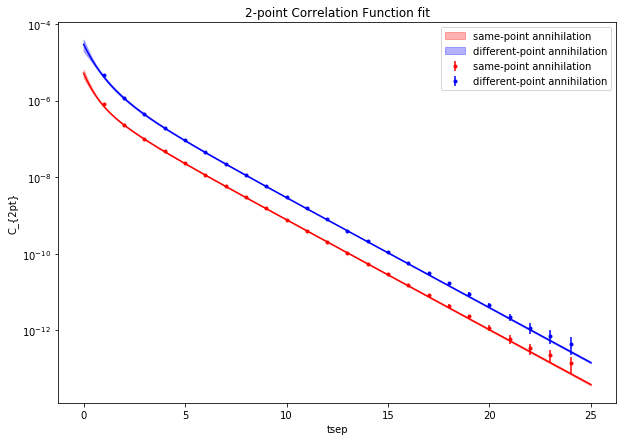

<Figure size 432x288 with 0 Axes>

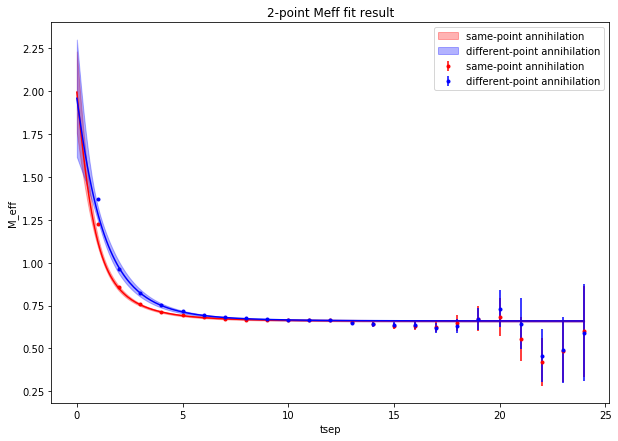

<Figure size 432x288 with 0 Axes>

In [136]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

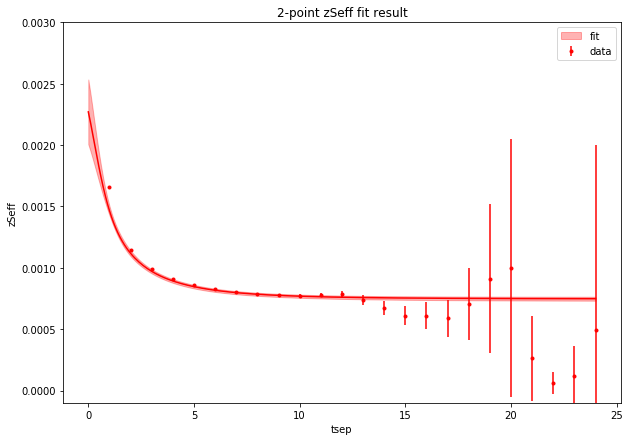

<Figure size 432x288 with 0 Axes>

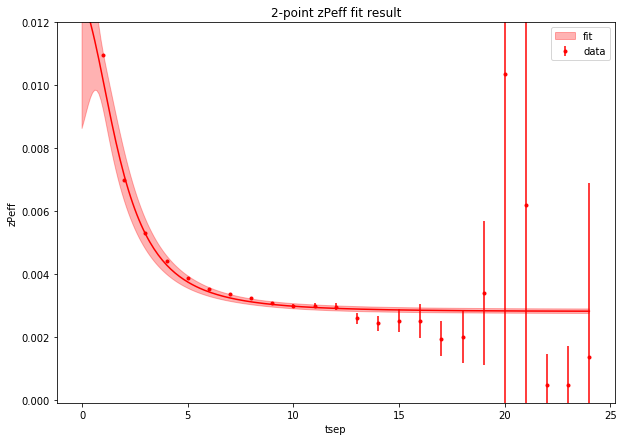

<Figure size 432x288 with 0 Axes>

In [137]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [138]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

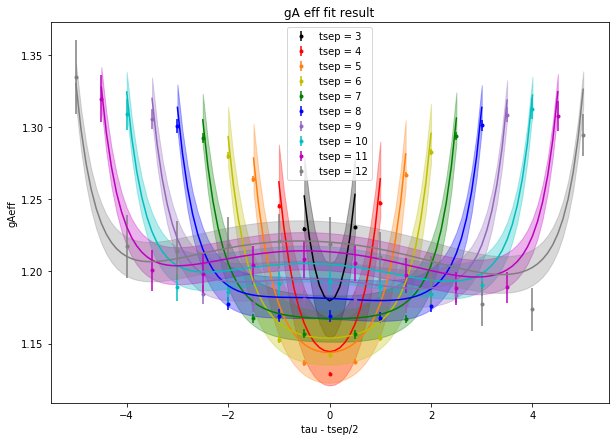

<Figure size 432x288 with 0 Axes>

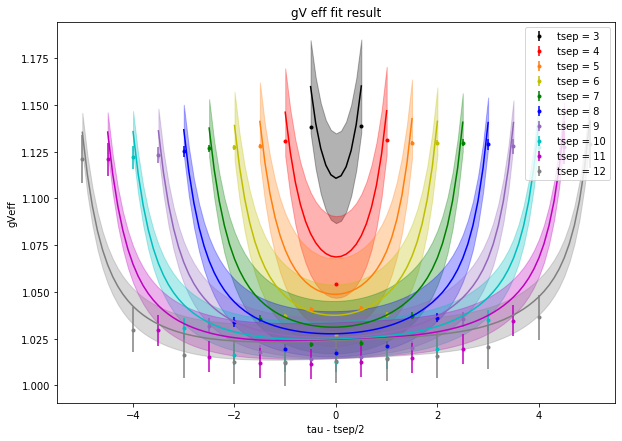

<Figure size 432x288 with 0 Axes>

In [139]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try completing the chain with a 3-point fit with tau cut off of 2

In [140]:
# Create a new set of priors
# Now try chain-fitting 2pt and 3-point
num_zs = 4
num_states_FH = 3

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

1


In [141]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [142]:

tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_2pt, fcn = C_3pt,debug=True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.4    logGBF = 2347.2

Parameters:
             E0       0.659344 +- 0.00233649             [     0.661027 +- 0.00280207 ]  
             Z0   0.000748891 +- 8.37061e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00282001 +- 3.72135e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)       -0.906833 +- 0.0810317             [        -0.8113 +- 0.135657 ]  
             Z1    0.00063179 +- 5.09522e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00413304 +- 0.000417609             [  0.00448214 +- 0.000764342 ]  
       log(dE2)       0.0650283 +- 0.0725679             [      -0.516866 +- 0.438609 ]  *
             Z2    0.00150352 +- 0.000178746             [  0.000799852 +- 0.00040447 ]  *
        Ztilde2      0.0113851 +- 0.00126911             [     0.0059393 +- 0.0030705 ]  *
       log(dE3)        -0.258606 +- 0.431087             [       -0.526875 +- 0.58489 ]  
          

In [143]:
current_posterior = open('chained_2pt_3pt_tau2_Final.obj', 'wb')
pickle.dump(post_3pt_tau2, current_posterior)
current_posterior.close()

In [144]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

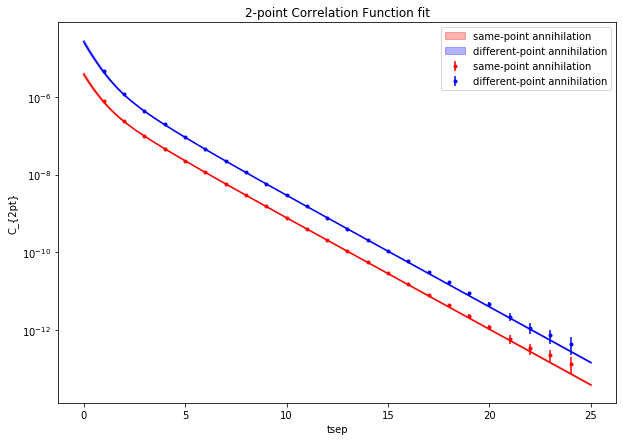

<Figure size 432x288 with 0 Axes>

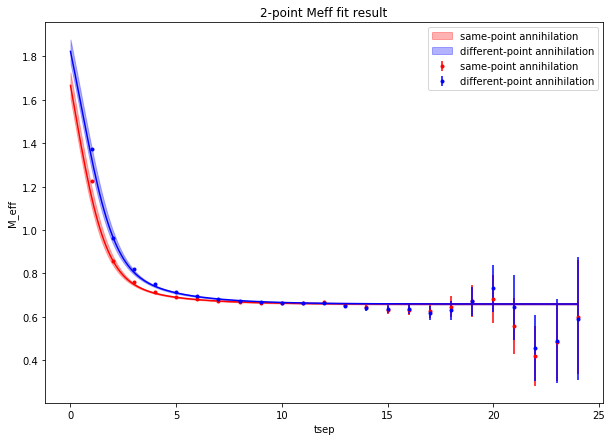

<Figure size 432x288 with 0 Axes>

In [145]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

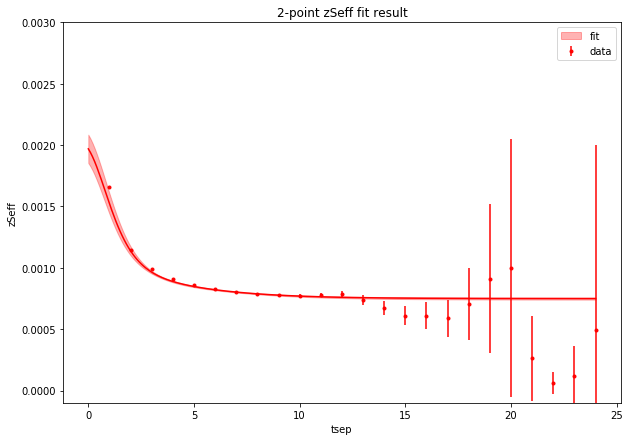

<Figure size 432x288 with 0 Axes>

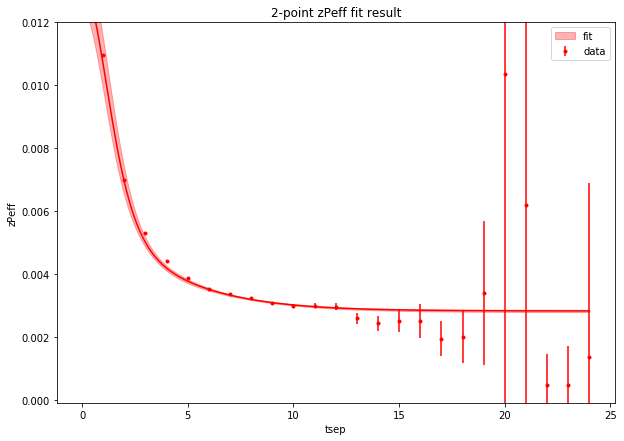

<Figure size 432x288 with 0 Axes>

In [146]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

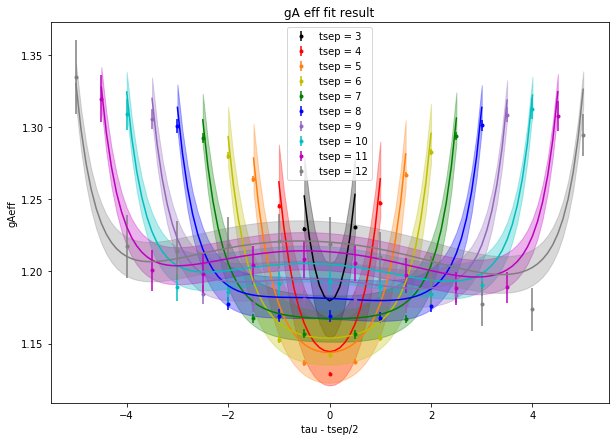

<Figure size 432x288 with 0 Axes>

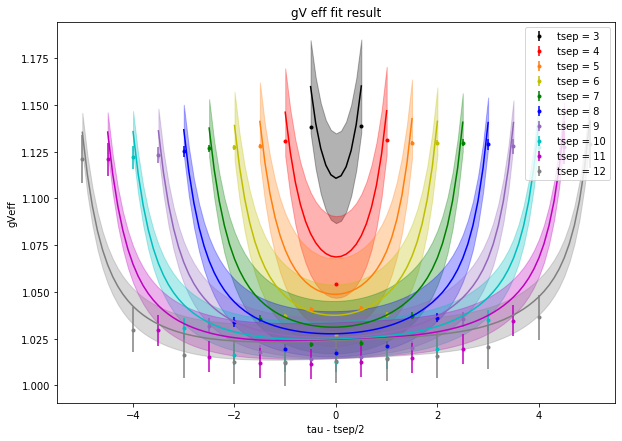

<Figure size 432x288 with 0 Axes>

In [147]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try the same, but with an insertion of Feynman-Hellman

In [148]:
# Now try chain-fitting 2pt and 3-point
num_zs = 7
num_states_FH = 2

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#tp['E1'] = gv.gvar(1.3, 0.23)
#tp['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#tp['Z1'] = gv.gvar(0.0012, 0.0006)
#tp['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = tp['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    tp["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
tp['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
tp['Ztilde_FHmax'] = gv.gvar(0, 0.01)
tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    tp['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
tp['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



#prior_2ptstep

0


In [149]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [150]:
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_2pt,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.82 [36]    Q = 0.77    logGBF = 135.4

Parameters:
             E0         0.659948 +- 0.0043592             [     0.659347 +- 0.00482406 ]  
             Z0    0.000750696 +- 2.06844e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0     0.00283142 +- 9.17312e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.04462 +- 0.433894             [       -1.07435 +- 0.453575 ]  
             Z1    0.000520538 +- 0.000192475             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1      0.00320713 +- 0.00163523             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -0.781371 +- 0.438272             [      -0.732238 +- 0.442562 ]  
             Z2     0.000736938 +- 0.00028496             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2      0.00645816 +- 0.00260838             [     0.0064959 +- 0.0026369 ]  
       log(dE3)         -0.893882 +- 0.644406             [      -0.853576 +- 0.645681 ]  


In [151]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])


fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.73 [130]    Q = 0.99    logGBF = 3324.9

Parameters:
             E0         0.66091 +- 0.00336565             [       0.659948 +- 0.0043592 ]  
             Z0      0.000751435 +- 1.505e-05             [  0.000750696 +- 2.06844e-05 ]  
        Ztilde0     0.00282637 +- 6.61418e-05             [   0.00283142 +- 9.17312e-05 ]  
       log(dE1)          -1.37449 +- 0.256549             [        -1.04462 +- 0.433894 ]  
             Z1    0.000290015 +- 0.000105943             [  0.000520538 +- 0.000192475 ]  *
        Ztilde1     0.00167914 +- 0.000915146             [    0.00320713 +- 0.00163523 ]  
       log(dE2)           -1.29777 +- 0.25014             [       -0.781371 +- 0.438272 ]  *
             Z2    0.000584869 +- 0.000168218             [   0.000736938 +- 0.00028496 ]  
        Ztilde2      0.00376692 +- 0.00178152             [    0.00645816 +- 0.00260838 ]  *
       log(dE3)         -0.830726 +- 0.471053             [       -0.893882 +

In [152]:
current_posterior = open('chained_2pt_3pt_withFH_Final.obj', 'wb')
pickle.dump(post_3pt, current_posterior)
current_posterior.close()

In [153]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

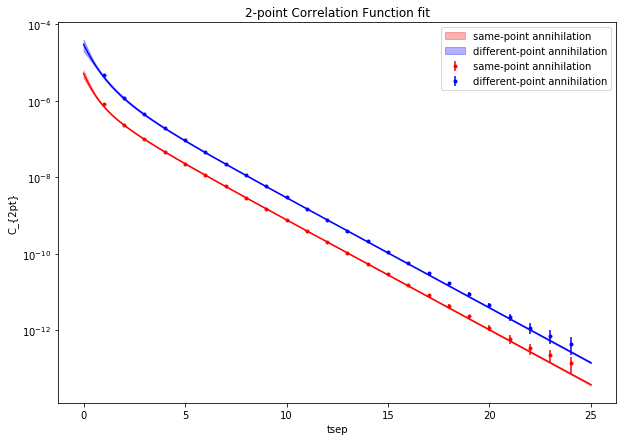

<Figure size 432x288 with 0 Axes>

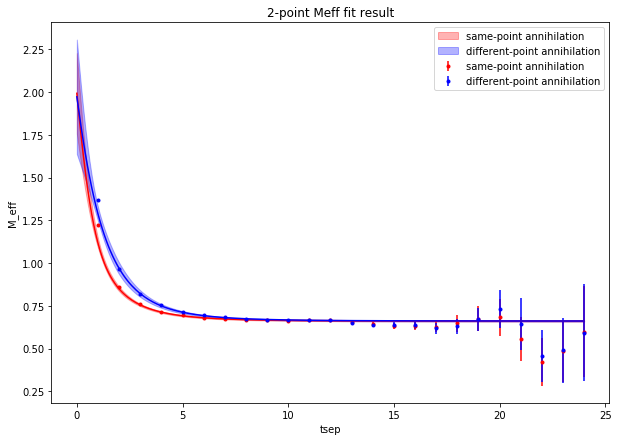

<Figure size 432x288 with 0 Axes>

In [154]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

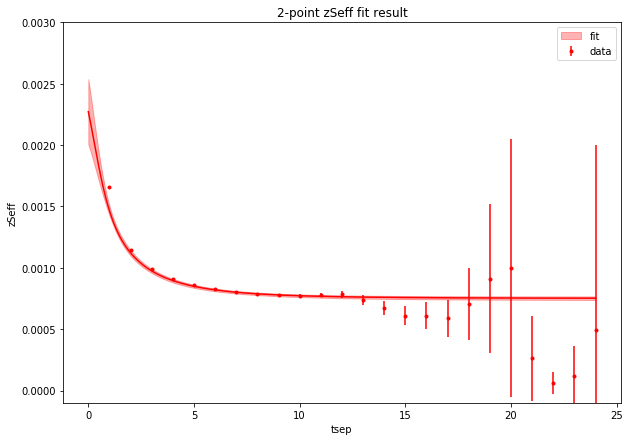

<Figure size 432x288 with 0 Axes>

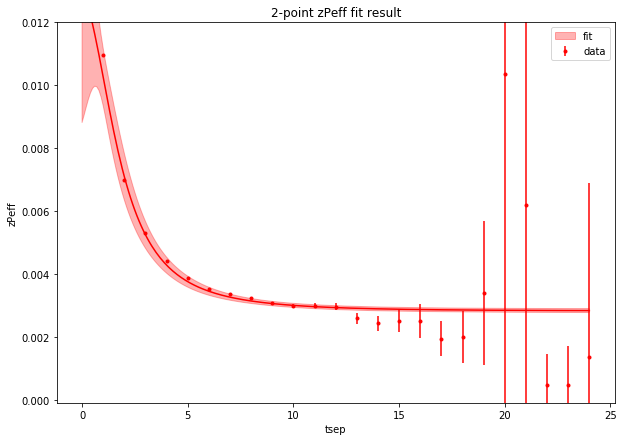

<Figure size 432x288 with 0 Axes>

In [155]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [156]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

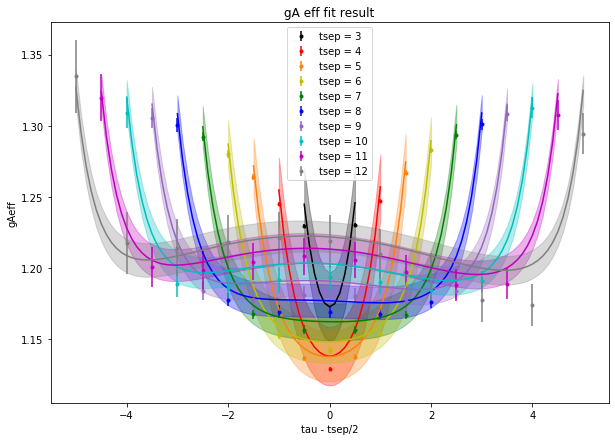

<Figure size 432x288 with 0 Axes>

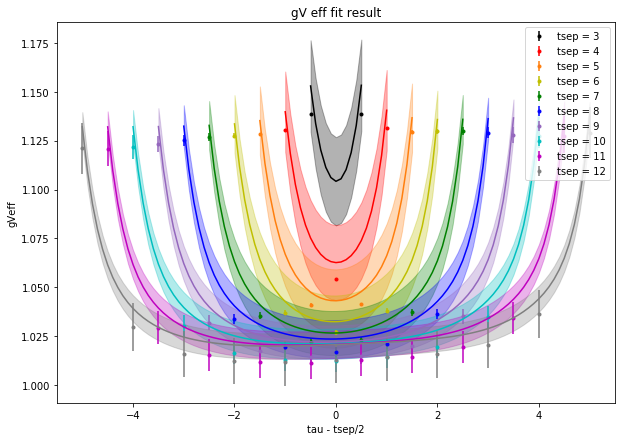

<Figure size 432x288 with 0 Axes>

In [157]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try completing the chain with a 3-point fit with tau cut off of 2

In [158]:
# Create a new set of priors
# Now try chain-fitting 2pt and 3-point
num_zs = 4
num_states_FH = 3


# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#tp['E1'] = gv.gvar(1.3, 0.23)
#tp['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#tp['Z1'] = gv.gvar(0.0012, 0.0006)
#tp['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = tp['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    tp["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
tp['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
tp['Ztilde_FHmax'] = gv.gvar(0, 0.01)
tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    tp['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
tp['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



#prior_2ptstep

1


In [159]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [160]:
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_2pt,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.75 [36]    Q = 0.86    logGBF = 118.47

Parameters:
             E0        0.661556 +- 0.00269559             [     0.661027 +- 0.00280207 ]  
             Z0    0.000759502 +- 9.93856e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0      0.00287291 +- 4.4697e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)         -0.775628 +- 0.128325             [        -0.8113 +- 0.135657 ]  
             Z1    0.000674932 +- 9.17117e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1     0.00465464 +- 0.000734107             [  0.00448214 +- 0.000764342 ]  
       log(dE2)         -0.518261 +- 0.437573             [      -0.516866 +- 0.438609 ]  
             Z2    0.000797966 +- 0.000404164             [  0.000799852 +- 0.00040447 ]  
        Ztilde2      0.00566248 +- 0.00306329             [     0.0059393 +- 0.0030705 ]  
       log(dE3)         -0.532845 +- 0.581165             [       -0.526875 +- 0.58489 ]  

In [161]:

tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_FHdata, fcn = C_3pt,debug=True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.22    logGBF = 2353.1

Parameters:
             E0        0.659566 +- 0.00220826             [      0.661556 +- 0.00269559 ]  
             Z0    0.000750855 +- 7.91539e-06             [  0.000759502 +- 9.93856e-06 ]  
        Ztilde0      0.0028313 +- 3.50428e-05             [    0.00287291 +- 4.4697e-05 ]  
       log(dE1)        -0.824499 +- 0.0747085             [       -0.775628 +- 0.128325 ]  
             Z1    0.000684731 +- 4.56596e-05             [  0.000674932 +- 9.17117e-05 ]  
        Ztilde1     0.00458065 +- 0.000382002             [   0.00465464 +- 0.000734107 ]  
       log(dE2)         0.029054 +- 0.0830538             [       -0.518261 +- 0.437573 ]  *
             Z2     0.00132445 +- 0.000156166             [  0.000797966 +- 0.000404164 ]  *
        Ztilde2      0.00988328 +- 0.00114589             [    0.00566248 +- 0.00306329 ]  *
       log(dE3)         -0.509117 +- 0.403681             [       -0.532845 +- 

In [162]:
current_posterior = open('chained_2pt_3pt_tau2_withFH_Final.obj', 'wb')
pickle.dump(post_3pt_tau2, current_posterior)
current_posterior.close()

In [163]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

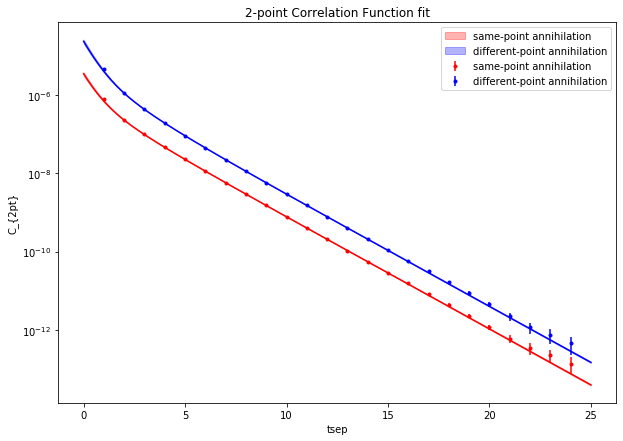

<Figure size 432x288 with 0 Axes>

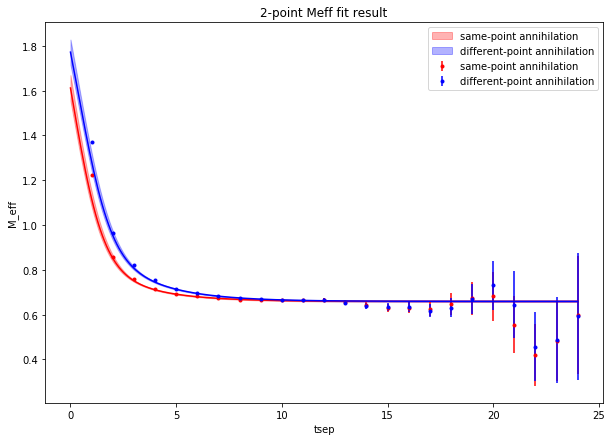

<Figure size 432x288 with 0 Axes>

In [164]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

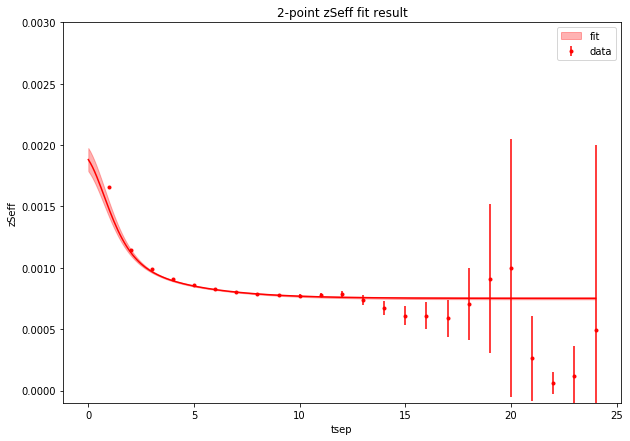

<Figure size 432x288 with 0 Axes>

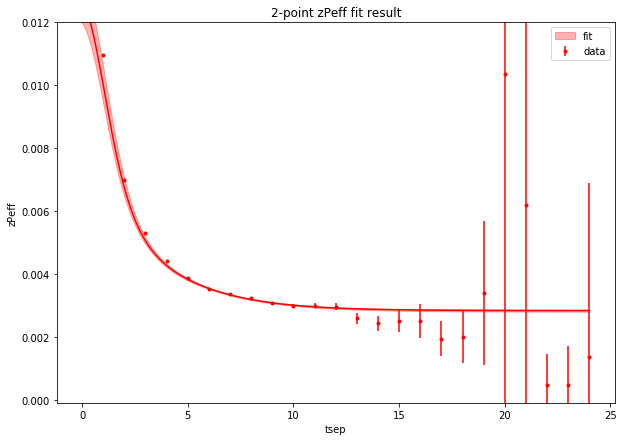

<Figure size 432x288 with 0 Axes>

In [165]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

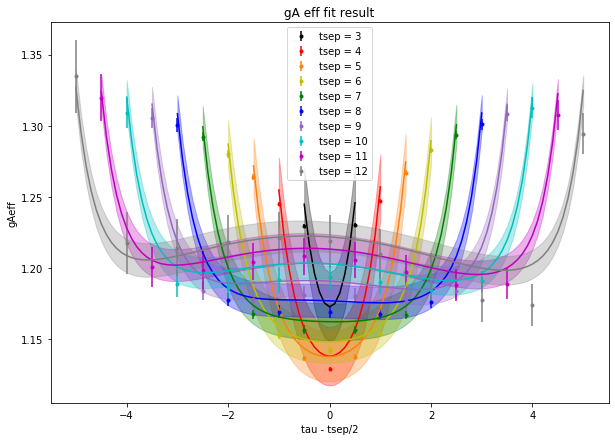

<Figure size 432x288 with 0 Axes>

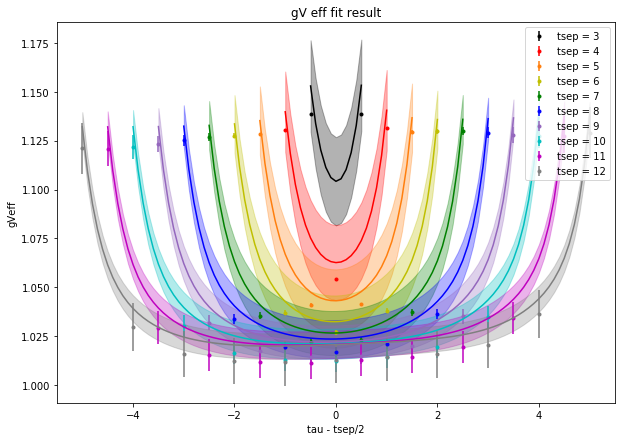

<Figure size 432x288 with 0 Axes>

In [166]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [69]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [70]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [52]:
list_LogGBF_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))


In [71]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])

In [54]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[0][i][k],fcn=C_2pt,debug=True)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[1][i][k],fcn=C_2pt,debug=True)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[2][i][k],fcn=C_2pt,debug=True)
                
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a0_2pt.p,fcn=C_3pt,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a1_2pt.p,fcn=C_3pt,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a2_2pt.p,fcn=C_3pt,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0_2pt[i][j][k] = fit_a0_2pt.logGBF
            list_LogGBF_a0_3pt[i][j][k] = fit_a0.logGBF
            list_Q_a0_2pt[i][j][k] = fit_a0_2pt.Q
            list_Q_a0_3pt[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv')) 
            list_LogGBF_a1_2pt[i][j][k] = fit_a1_2pt.logGBF
            list_LogGBF_a1_3pt[i][j][k] = fit_a1.logGBF
            list_Q_a1_2pt[i][j][k] = fit_a1_2pt.Q
            list_Q_a1_3pt[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a2.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2_2pt[i][j][k] = fit_a2_2pt.logGBF
            list_LogGBF_a2_3pt[i][j][k] = fit_a2.logGBF
            list_Q_a2_2pt[i][j][k] = fit_a2_2pt.Q
            list_Q_a2_3pt[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 32 [130]    Q = 0    logGBF = 1397.5

Parameters:
             E0       0.679425 +- 0.00102799             [     0.660763 +- 0.00194013 ]  *****
             Z0   0.000804627 +- 2.65809e-06             [ 0.000755481 +- 6.18476e-06 ]  *****
        Ztilde0    0.00310733 +- 1.19243e-05             [   0.00285135 +- 2.8959e-05 ]  *****
       log(dE1)      -0.100591 +- 0.00793038             [       -0.8198 +- 0.0578138 ]  *****
             Z1    0.00112584 +- 5.69222e-06             [ 0.000679381 +- 3.50719e-05 ]  *****
        Ztilde1     0.00841447 +- 4.9921e-05             [   0.0045985 +- 0.000250554 ]  *****
       log(dE2)       0.831199 +- 0.00607061             [     -0.125217 +- 0.0425782 ]  *****
             Z2    0.00182553 +- 6.51905e-06             [  0.00132388 +- 1.75388e-05 ]  *****
        Ztilde2     0.0137996 +- 6.28709e-05             [  0.00984182

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 32 [130]    Q = 0    logGBF = 1397.5

Parameters:
             E0       0.679425 +- 0.00102799             [     0.660763 +- 0.00194013 ]  *****
             Z0   0.000804627 +- 2.65809e-06             [ 0.000755481 +- 6.18476e-06 ]  *****
        Ztilde0    0.00310733 +- 1.19243e-05             [   0.00285135 +- 2.8959e-05 ]  *****
       log(dE1)      -0.100591 +- 0.00793038             [       -0.8198 +- 0.0578138 ]  *****
             Z1    0.00112584 +- 5.69222e-06             [ 0.000679381 +- 3.50719e-05 ]  *****
        Ztilde1     0.00841447 +- 4.9921e-05             [   0.0045985 +- 0.000250554 ]  *****
       log(dE2)       0.831199 +- 0.00607061             [     -0.125217 +- 0.0425782 ]  *****
             Z2    0.00182553 +- 6.51905e-06             [  0.00132388 +- 1.75388e-05 ]  *****
        Ztilde2     0.0137996 +- 6.28709e-05             [  0.00984182

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 3.6 [130]    Q = 3.5e-40    logGBF = 3226.7

Parameters:
             E0        0.680475 +- 0.00110664             [      0.66017 +- 0.00311819 ]  *****
             Z0    0.000820862 +- 3.09839e-06             [ 0.000752509 +- 1.16599e-05 ]  *****
        Ztilde0     0.00309776 +- 1.46318e-05             [  0.00283822 +- 4.98331e-05 ]  *****
       log(dE1)         -1.43669 +- 0.0440437             [     -0.964082 +- 0.0958084 ]  ****
             Z1   -9.19212e-05 +- 2.02284e-05             [ 0.000558573 +- 9.46835e-05 ]  *****
        Ztilde1     0.00104346 +- 0.000178846             [  0.00363474 +- 0.000563347 ]  ****
       log(dE2)        -0.232161 +- 0.0270174             [      -0.766081 +- 0.488679 ]  *
             Z2     0.00215336 +- 3.66846e-05             [ 0.000778734 +- 0.000296933 ]  ****
        Ztilde2      0.0124503 +- 0.000316386             [   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 3.6 [130]    Q = 3.5e-40    logGBF = 3226.7

Parameters:
             E0        0.680475 +- 0.00110664             [      0.66017 +- 0.00311819 ]  *****
             Z0    0.000820862 +- 3.09839e-06             [ 0.000752509 +- 1.16599e-05 ]  *****
        Ztilde0     0.00309776 +- 1.46318e-05             [  0.00283822 +- 4.98331e-05 ]  *****
       log(dE1)         -1.43669 +- 0.0440437             [     -0.964082 +- 0.0958084 ]  ****
             Z1   -9.19212e-05 +- 2.02284e-05             [ 0.000558573 +- 9.46835e-05 ]  *****
        Ztilde1     0.00104346 +- 0.000178846             [  0.00363474 +- 0.000563347 ]  ****
       log(dE2)        -0.232161 +- 0.0270174             [      -0.766081 +- 0.488679 ]  *
             Z2     0.00215336 +- 3.66846e-05             [ 0.000778734 +- 0.000296933 ]  ****
        Ztilde2      0.0124503 +- 0.000316386             [   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.041    logGBF = 3346.4

Parameters:
             E0       0.655876 +- 0.00227954             [     0.659605 +- 0.00329025 ]  *
             Z0   0.000735504 +- 8.39912e-06             [ 0.000749922 +- 1.26049e-05 ]  *
        Ztilde0    0.00276543 +- 3.56773e-05             [  0.00282888 +- 5.29096e-05 ]  *
       log(dE1)        -0.87585 +- 0.0516031             [     -0.979227 +- 0.0971999 ]  *
             Z1     0.000727121 +- 3.026e-05             [ 0.000569519 +- 8.43534e-05 ]  *
        Ztilde1    0.00457378 +- 0.000222781             [  0.00356033 +- 0.000528734 ]  *
       log(dE2)        0.168878 +- 0.0624575             [      -0.713988 +- 0.424306 ]  **
             Z2    0.00119884 +- 9.53844e-05             [ 0.000742327 +- 0.000315844 ]  *
        Ztilde2      0.0105542 +- 0.00108965             [   0.00649232 +- 0.00254085 ]  *
     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.041    logGBF = 3346.4

Parameters:
             E0       0.655876 +- 0.00227954             [     0.659605 +- 0.00329025 ]  *
             Z0   0.000735504 +- 8.39912e-06             [ 0.000749922 +- 1.26049e-05 ]  *
        Ztilde0    0.00276543 +- 3.56773e-05             [  0.00282888 +- 5.29096e-05 ]  *
       log(dE1)        -0.87585 +- 0.0516031             [     -0.979227 +- 0.0971999 ]  *
             Z1     0.000727121 +- 3.026e-05             [ 0.000569519 +- 8.43534e-05 ]  *
        Ztilde1    0.00457378 +- 0.000222781             [  0.00356033 +- 0.000528734 ]  *
       log(dE2)        0.168878 +- 0.0624575             [      -0.713988 +- 0.424306 ]  **
             Z2    0.00119884 +- 9.53844e-05             [ 0.000742327 +- 0.000315844 ]  *
        Ztilde2      0.0105542 +- 0.00108965             [   0.00649232 +- 0.00254085 ]  *
     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [130]    Q = 9.1e-06    logGBF = 3265.8

Parameters:
             E0        0.670849 +- 0.00212937             [     0.659839 +- 0.00334305 ]  ***
             Z0      0.000786973 +- 7.638e-06             [ 0.000750893 +- 1.28799e-05 ]  **
        Ztilde0     0.00295494 +- 3.24329e-05             [  0.00283276 +- 5.40395e-05 ]  **
       log(dE1)         -1.57152 +- 0.0515511             [     -0.982934 +- 0.0975408 ]  *****
             Z1   -3.01051e-05 +- 1.48763e-05             [ 0.000559628 +- 9.08169e-05 ]  *****
        Ztilde1    0.000683717 +- 0.000236572             [  0.00352605 +- 0.000536794 ]  *****
       log(dE2)        -0.411426 +- 0.0997589             [      -0.726969 +- 0.440483 ]  
             Z2     0.00214719 +- 0.000165192             [   0.000751501 +- 0.0003099 ]  ****
        Ztilde2       0.0108542 +- 0.00122651             [   0.00638

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [130]    Q = 9.1e-06    logGBF = 3265.8

Parameters:
             E0        0.670849 +- 0.00212937             [     0.659839 +- 0.00334305 ]  ***
             Z0      0.000786973 +- 7.638e-06             [ 0.000750893 +- 1.28799e-05 ]  **
        Ztilde0     0.00295494 +- 3.24329e-05             [  0.00283276 +- 5.40395e-05 ]  **
       log(dE1)         -1.57152 +- 0.0515511             [     -0.982934 +- 0.0975408 ]  *****
             Z1   -3.01051e-05 +- 1.48763e-05             [ 0.000559628 +- 9.08169e-05 ]  *****
        Ztilde1    0.000683717 +- 0.000236572             [  0.00352605 +- 0.000536794 ]  *****
       log(dE2)        -0.411426 +- 0.0997589             [      -0.726969 +- 0.440483 ]  
             Z2     0.00214719 +- 0.000165192             [   0.000751501 +- 0.0003099 ]  ****
        Ztilde2       0.0108542 +- 0.00122651             [   0.00638

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3334.2

Parameters:
             E0       0.663684 +- 0.00283837             [     0.660121 +- 0.00338817 ]  *
             Z0   0.000765514 +- 1.07695e-05             [ 0.000752082 +- 1.31002e-05 ]  *
        Ztilde0    0.00289111 +- 4.51725e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)         -1.0016 +- 0.0885978             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000431946 +- 7.51006e-05             [ 0.000550927 +- 9.69924e-05 ]  *
        Ztilde1     0.0031048 +- 0.000437629             [  0.00351932 +- 0.000537723 ]  
       log(dE2)         -1.12562 +- 0.240529             [      -0.722836 +- 0.434256 ]  
             Z2   0.000712685 +- 0.000157007             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2       0.0040713 +- 0.0018057             [   0.00632795 +- 0.00276443 ]  
       log(d

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3334.2

Parameters:
             E0       0.663684 +- 0.00283837             [     0.660121 +- 0.00338817 ]  *
             Z0   0.000765514 +- 1.07695e-05             [ 0.000752082 +- 1.31002e-05 ]  *
        Ztilde0    0.00289111 +- 4.51725e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)         -1.0016 +- 0.0885978             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000431946 +- 7.51006e-05             [ 0.000550927 +- 9.69924e-05 ]  *
        Ztilde1     0.0031048 +- 0.000437629             [  0.00351932 +- 0.000537723 ]  
       log(dE2)         -1.12562 +- 0.240529             [      -0.722836 +- 0.434256 ]  
             Z2   0.000712685 +- 0.000157007             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2       0.0040713 +- 0.0018057             [   0.00632795 +- 0.00276443 ]  
       log(d

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 5.5e-06    logGBF = 2328.2

Parameters:
             E0        0.661019 +- 0.0017457             [     0.660763 +- 0.00194013 ]  
             Z0   0.000753088 +- 5.54589e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00282908 +- 2.58255e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.992745 +- 0.0316822             [       -0.8198 +- 0.0578138 ]  **
             Z1   0.000560716 +- 1.31025e-05             [ 0.000679381 +- 3.50719e-05 ]  ***
        Ztilde1     0.0037651 +- 0.000101445             [   0.0045985 +- 0.000250554 ]  ***
       log(dE2)       -0.262447 +- 0.0191072             [     -0.125217 +- 0.0425782 ]  ***
             Z2    0.00127685 +- 1.16356e-05             [  0.00132388 +- 1.75388e-05 ]  **
        Ztilde2    0.00935393 +- 0.000121461             [  0.00984182 +- 0.000188411 ]  **

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 5.5e-06    logGBF = 2328.2

Parameters:
             E0        0.661019 +- 0.0017457             [     0.660763 +- 0.00194013 ]  
             Z0   0.000753088 +- 5.54589e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00282908 +- 2.58255e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.992745 +- 0.0316822             [       -0.8198 +- 0.0578138 ]  **
             Z1   0.000560716 +- 1.31025e-05             [ 0.000679381 +- 3.50719e-05 ]  ***
        Ztilde1     0.0037651 +- 0.000101445             [   0.0045985 +- 0.000250554 ]  ***
       log(dE2)       -0.262447 +- 0.0191072             [     -0.125217 +- 0.0425782 ]  ***
             Z2    0.00127685 +- 1.16356e-05             [  0.00132388 +- 1.75388e-05 ]  **
        Ztilde2    0.00935393 +- 0.000121461             [  0.00984182 +- 0.000188411 ]  **

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.29    logGBF = 2340.4

Parameters:
             E0        0.66085 +- 0.00276012             [      0.66017 +- 0.00311819 ]  
             Z0   0.000753254 +- 1.03024e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0     0.0028351 +- 4.42282e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)        -1.12057 +- 0.0841532             [     -0.964082 +- 0.0958084 ]  *
             Z1   0.000411452 +- 7.62303e-05             [ 0.000558573 +- 9.46835e-05 ]  *
        Ztilde1    0.00265401 +- 0.000450533             [  0.00363474 +- 0.000563347 ]  *
       log(dE2)         -1.66574 +- 0.236752             [      -0.766081 +- 0.488679 ]  *
             Z2   0.000234858 +- 7.18801e-05             [ 0.000778734 +- 0.000296933 ]  *
        Ztilde2    0.00141801 +- 0.000720691             [   0.00579599 +- 0.00217274 ]  **
       log

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.29    logGBF = 2340.4

Parameters:
             E0        0.66085 +- 0.00276012             [      0.66017 +- 0.00311819 ]  
             Z0   0.000753254 +- 1.03024e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0     0.0028351 +- 4.42282e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)        -1.12057 +- 0.0841532             [     -0.964082 +- 0.0958084 ]  *
             Z1   0.000411452 +- 7.62303e-05             [ 0.000558573 +- 9.46835e-05 ]  *
        Ztilde1    0.00265401 +- 0.000450533             [  0.00363474 +- 0.000563347 ]  *
       log(dE2)         -1.66574 +- 0.236752             [      -0.766081 +- 0.488679 ]  *
             Z2   0.000234858 +- 7.18801e-05             [ 0.000778734 +- 0.000296933 ]  *
        Ztilde2    0.00141801 +- 0.000720691             [   0.00579599 +- 0.00217274 ]  **
       log

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.97    logGBF = 2335

Parameters:
             E0       0.660585 +- 0.00305703             [     0.659605 +- 0.00329025 ]  
             Z0   0.000752984 +- 1.16938e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00284126 +- 4.93591e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)        -1.01776 +- 0.0902669             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000508019 +- 7.64873e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00316917 +- 0.000455779             [  0.00356033 +- 0.000528734 ]  
       log(dE2)         -1.04917 +- 0.314611             [      -0.713988 +- 0.424306 ]  
             Z2    0.000576352 +- 0.00019612             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00484516 +- 0.00212546             [   0.00649232 +- 0.00254085 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.97    logGBF = 2335

Parameters:
             E0       0.660585 +- 0.00305703             [     0.659605 +- 0.00329025 ]  
             Z0   0.000752984 +- 1.16938e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00284126 +- 4.93591e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)        -1.01776 +- 0.0902669             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000508019 +- 7.64873e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00316917 +- 0.000455779             [  0.00356033 +- 0.000528734 ]  
       log(dE2)         -1.04917 +- 0.314611             [      -0.713988 +- 0.424306 ]  
             Z2    0.000576352 +- 0.00019612             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00484516 +- 0.00212546             [   0.00649232 +- 0.00254085 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.96    logGBF = 2333

Parameters:
             E0       0.660828 +- 0.00309901             [     0.659839 +- 0.00334305 ]  
             Z0   0.000754035 +- 1.19296e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00284529 +- 5.01974e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)        -1.02042 +- 0.0911816             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000497692 +- 8.07223e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00314483 +- 0.000468081             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -1.07478 +- 0.335859             [      -0.726969 +- 0.440483 ]  
             Z2   0.000551543 +- 0.000211278             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00456546 +- 0.00230283             [   0.00638306 +- 0.00277991 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.96    logGBF = 2333

Parameters:
             E0       0.660828 +- 0.00309901             [     0.659839 +- 0.00334305 ]  
             Z0   0.000754035 +- 1.19296e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00284529 +- 5.01974e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)        -1.02042 +- 0.0911816             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000497692 +- 8.07223e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00314483 +- 0.000468081             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -1.07478 +- 0.335859             [      -0.726969 +- 0.440483 ]  
             Z2   0.000551543 +- 0.000211278             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00456546 +- 0.00230283             [   0.00638306 +- 0.00277991 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.76 [90]    Q = 0.96    logGBF = 2332.2

Parameters:
             E0       0.661186 +- 0.00311521             [     0.660121 +- 0.00338817 ]  
             Z0    0.000755605 +- 1.2014e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00285116 +- 5.05042e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.02252 +- 0.0914206             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000483036 +- 8.43619e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1    0.00312548 +- 0.000467118             [  0.00351932 +- 0.000537723 ]  
       log(dE2)         -1.09203 +- 0.324761             [      -0.722836 +- 0.434256 ]  
             Z2   0.000556146 +- 0.000200809             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2      0.00433077 +- 0.0022176             [   0.00632795 +- 0.00276443 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [90]    Q = 0.96    logGBF = 2332.2

Parameters:
             E0       0.661186 +- 0.00311521             [     0.660121 +- 0.00338817 ]  
             Z0    0.000755605 +- 1.2014e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00285116 +- 5.05042e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.02252 +- 0.0914206             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000483036 +- 8.43619e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1    0.00312548 +- 0.000467118             [  0.00351932 +- 0.000537723 ]  
       log(dE2)         -1.09203 +- 0.324761             [      -0.722836 +- 0.434256 ]  
             Z2   0.000556146 +- 0.000200809             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2      0.00433077 +- 0.0022176             [   0.00632795 +- 0.00276443 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.21    logGBF = 1458.3

Parameters:
             E0       0.659769 +- 0.00186097             [     0.660763 +- 0.00194013 ]  
             Z0   0.000750897 +- 5.93829e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00282969 +- 2.77845e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.840539 +- 0.0523602             [       -0.8198 +- 0.0578138 ]  
             Z1    0.000678472 +- 3.0696e-05             [ 0.000679381 +- 3.50719e-05 ]  
        Ztilde1    0.00453518 +- 0.000221168             [   0.0045985 +- 0.000250554 ]  
       log(dE2)       -0.119345 +- 0.0370513             [     -0.125217 +- 0.0425782 ]  
             Z2    0.00132332 +- 1.58163e-05             [  0.00132388 +- 1.75388e-05 ]  
        Ztilde2     0.0098854 +- 0.000170443             [  0.00984182 +- 0.000188411 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [56]    Q = 0.21    logGBF = 1458.3

Parameters:
             E0       0.659769 +- 0.00186097             [     0.660763 +- 0.00194013 ]  
             Z0   0.000750897 +- 5.93829e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00282969 +- 2.77845e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.840539 +- 0.0523602             [       -0.8198 +- 0.0578138 ]  
             Z1    0.000678472 +- 3.0696e-05             [ 0.000679381 +- 3.50719e-05 ]  
        Ztilde1    0.00453518 +- 0.000221168             [   0.0045985 +- 0.000250554 ]  
       log(dE2)       -0.119345 +- 0.0370513             [     -0.125217 +- 0.0425782 ]  
             Z2    0.00132332 +- 1.58163e-05             [  0.00132388 +- 1.75388e-05 ]  
        Ztilde2     0.0098854 +- 0.000170443             [  0.00984182 +- 0.000188411 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1455.8

Parameters:
             E0       0.660128 +- 0.00296372             [      0.66017 +- 0.00311819 ]  
             Z0   0.000751912 +- 1.11024e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0    0.00283453 +- 4.75047e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)       -0.991894 +- 0.0907175             [     -0.964082 +- 0.0958084 ]  
             Z1   0.000526651 +- 8.61729e-05             [ 0.000558573 +- 9.46835e-05 ]  
        Ztilde1     0.0034214 +- 0.000499489             [  0.00363474 +- 0.000563347 ]  
       log(dE2)        -0.998963 +- 0.358744             [      -0.766081 +- 0.488679 ]  
             Z2   0.000651476 +- 0.000208435             [ 0.000778734 +- 0.000296933 ]  
        Ztilde2      0.0047506 +- 0.00152937             [   0.00579599 +- 0.00217274 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1455.8

Parameters:
             E0       0.660128 +- 0.00296372             [      0.66017 +- 0.00311819 ]  
             Z0   0.000751912 +- 1.11024e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0    0.00283453 +- 4.75047e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)       -0.991894 +- 0.0907175             [     -0.964082 +- 0.0958084 ]  
             Z1   0.000526651 +- 8.61729e-05             [ 0.000558573 +- 9.46835e-05 ]  
        Ztilde1     0.0034214 +- 0.000499489             [  0.00363474 +- 0.000563347 ]  
       log(dE2)        -0.998963 +- 0.358744             [      -0.766081 +- 0.488679 ]  
             Z2   0.000651476 +- 0.000208435             [ 0.000778734 +- 0.000296933 ]  
        Ztilde2      0.0047506 +- 0.00152937             [   0.00579599 +- 0.00217274 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1453.7

Parameters:
             E0       0.659609 +- 0.00310274             [     0.659605 +- 0.00329025 ]  
             Z0   0.000749416 +- 1.18842e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0     0.0028262 +- 4.99838e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)        -1.02627 +- 0.0937101             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000525471 +- 7.76621e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00321942 +- 0.000486902             [  0.00356033 +- 0.000528734 ]  
       log(dE2)        -0.954456 +- 0.353762             [      -0.713988 +- 0.424306 ]  
             Z2    0.00061666 +- 0.000261314             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00545531 +- 0.00223404             [   0.00649232 +- 0.00254085 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1453.7

Parameters:
             E0       0.659609 +- 0.00310274             [     0.659605 +- 0.00329025 ]  
             Z0   0.000749416 +- 1.18842e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0     0.0028262 +- 4.99838e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)        -1.02627 +- 0.0937101             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000525471 +- 7.76621e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00321942 +- 0.000486902             [  0.00356033 +- 0.000528734 ]  
       log(dE2)        -0.954456 +- 0.353762             [      -0.713988 +- 0.424306 ]  
             Z2    0.00061666 +- 0.000261314             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00545531 +- 0.00223404             [   0.00649232 +- 0.00254085 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1453.5

Parameters:
             E0        0.659807 +- 0.0031323             [     0.659839 +- 0.00334305 ]  
             Z0    0.00075029 +- 1.20479e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00282943 +- 5.05847e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)        -1.02552 +- 0.0938652             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000520369 +- 8.13878e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00323094 +- 0.000487189             [  0.00352605 +- 0.000536794 ]  
       log(dE2)        -0.925302 +- 0.358016             [      -0.726969 +- 0.440483 ]  
             Z2   0.000644112 +- 0.000260062             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00548573 +- 0.00238249             [   0.00638306 +- 0.00277991 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1453.5

Parameters:
             E0        0.659807 +- 0.0031323             [     0.659839 +- 0.00334305 ]  
             Z0    0.00075029 +- 1.20479e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00282943 +- 5.05847e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)        -1.02552 +- 0.0938652             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000520369 +- 8.13878e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00323094 +- 0.000487189             [  0.00352605 +- 0.000536794 ]  
       log(dE2)        -0.925302 +- 0.358016             [      -0.726969 +- 0.440483 ]  
             Z2   0.000644112 +- 0.000260062             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00548573 +- 0.00238249             [   0.00638306 +- 0.00277991 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [56]    Q = 0.94    logGBF = 1453.9

Parameters:
             E0       0.660055 +- 0.00315055             [     0.660121 +- 0.00338817 ]  
             Z0    0.00075136 +- 1.21455e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00283329 +- 5.10012e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.02069 +- 0.0936561             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000517447 +- 8.50843e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1    0.00327091 +- 0.000483307             [  0.00351932 +- 0.000537723 ]  
       log(dE2)        -0.884486 +- 0.347878             [      -0.722836 +- 0.434256 ]  
             Z2   0.000684068 +- 0.000246341             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00558195 +- 0.00232607             [   0.00632795 +- 0.00276443 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [56]    Q = 0.94    logGBF = 1453.9

Parameters:
             E0       0.660055 +- 0.00315055             [     0.660121 +- 0.00338817 ]  
             Z0    0.00075136 +- 1.21455e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00283329 +- 5.10012e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.02069 +- 0.0936561             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000517447 +- 8.50843e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1    0.00327091 +- 0.000483307             [  0.00351932 +- 0.000537723 ]  
       log(dE2)        -0.884486 +- 0.347878             [      -0.722836 +- 0.434256 ]  
             Z2   0.000684068 +- 0.000246341             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00558195 +- 0.00232607             [   0.00632795 +- 0.00276443 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1694.2

Parameters:
             E0       0.678043 +- 0.00101957             [       0.661262 +- 0.001864 ]  *****
             Z0   0.000803222 +- 2.61237e-06             [ 0.000758267 +- 5.88992e-06 ]  *****
        Ztilde0     0.00310911 +- 1.1769e-05             [  0.00286826 +- 2.81426e-05 ]  *****
       log(dE1)      -0.082003 +- 0.00760119             [     -0.750973 +- 0.0636921 ]  *****
             Z1    0.00115058 +- 5.81206e-06             [ 0.000717035 +- 4.13974e-05 ]  *****
        Ztilde1     0.00864085 +- 5.1359e-05             [  0.00490633 +- 0.000310126 ]  *****
       log(dE2)       0.849201 +- 0.00662161             [    -0.0946006 +- 0.0542591 ]  *****
             Z2    0.00184865 +- 7.29721e-06             [  0.00133282 +- 2.32641e-05 ]  *****
        Ztilde2     0.0138264 +- 6.94366e-05             [  0.00991329

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 28 [130]    Q = 0    logGBF = 1694.2

Parameters:
             E0       0.678043 +- 0.00101957             [       0.661262 +- 0.001864 ]  *****
             Z0   0.000803222 +- 2.61237e-06             [ 0.000758267 +- 5.88992e-06 ]  *****
        Ztilde0     0.00310911 +- 1.1769e-05             [  0.00286826 +- 2.81426e-05 ]  *****
       log(dE1)      -0.082003 +- 0.00760119             [     -0.750973 +- 0.0636921 ]  *****
             Z1    0.00115058 +- 5.81206e-06             [ 0.000717035 +- 4.13974e-05 ]  *****
        Ztilde1     0.00864085 +- 5.1359e-05             [  0.00490633 +- 0.000310126 ]  *****
       log(dE2)       0.849201 +- 0.00662161             [    -0.0946006 +- 0.0542591 ]  *****
             Z2    0.00184865 +- 7.29721e-06             [  0.00133282 +- 2.32641e-05 ]  *****
        Ztilde2     0.0138264 +- 6.94366e-05             [  0.00991329

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 1.9e-20    logGBF = 3276.9

Parameters:
             E0       0.66275 +- 0.00204852            [     0.660577 +- 0.00300591 ]  
             Z0   0.00076312 +- 7.08118e-06            [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0   0.00288826 +- 3.06518e-05            [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)      -0.891917 +- 0.0572389            [      -0.882707 +- 0.174874 ]  
             Z1    0.00050538 +- 3.4808e-05            [ 0.000611861 +- 0.000126893 ]  
        Ztilde1   0.00361181 +- 0.000240866            [   0.0040643 +- 0.000960595 ]  
       log(dE2)      -0.464702 +- 0.0545263            [      -0.663524 +- 0.517413 ]  
             Z2   0.00156918 +- 6.28596e-05            [ 0.000777956 +- 0.000357367 ]  **
        Ztilde2    0.0107408 +- 0.000541385            [   0.00580809 +- 0.00263897 ]  *
       log(dE3)        1.288

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.6 [130]    Q = 1.9e-20    logGBF = 3276.9

Parameters:
             E0       0.66275 +- 0.00204852            [     0.660577 +- 0.00300591 ]  
             Z0   0.00076312 +- 7.08118e-06            [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0   0.00288826 +- 3.06518e-05            [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)      -0.891917 +- 0.0572389            [      -0.882707 +- 0.174874 ]  
             Z1    0.00050538 +- 3.4808e-05            [ 0.000611861 +- 0.000126893 ]  
        Ztilde1   0.00361181 +- 0.000240866            [   0.0040643 +- 0.000960595 ]  
       log(dE2)      -0.464702 +- 0.0545263            [      -0.663524 +- 0.517413 ]  
             Z2   0.00156918 +- 6.28596e-05            [ 0.000777956 +- 0.000357367 ]  **
        Ztilde2    0.0107408 +- 0.000541385            [   0.00580809 +- 0.00263897 ]  *
       log(dE3)        1.288

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.05    logGBF = 3346.8

Parameters:
             E0       0.656076 +- 0.00234345             [     0.659435 +- 0.00390573 ]  
             Z0   0.000736566 +- 8.84736e-06             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00276975 +- 3.76975e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)       -0.853963 +- 0.0586673             [       -0.99783 +- 0.248314 ]  
             Z1   0.000732371 +- 2.89804e-05             [  0.000561969 +- 0.00012922 ]  *
        Ztilde1    0.00465279 +- 0.000230511             [   0.00348387 +- 0.00110222 ]  *
       log(dE2)         0.162723 +- 0.062945             [      -0.718406 +- 0.440565 ]  *
             Z2    0.00119789 +- 9.22403e-05             [  0.00074424 +- 0.000309818 ]  *
        Ztilde2      0.0105403 +- 0.00106045             [   0.00653126 +- 0.00249658 ]  *
       log(

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.05    logGBF = 3346.8

Parameters:
             E0       0.656076 +- 0.00234345             [     0.659435 +- 0.00390573 ]  
             Z0   0.000736566 +- 8.84736e-06             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00276975 +- 3.76975e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)       -0.853963 +- 0.0586673             [       -0.99783 +- 0.248314 ]  
             Z1   0.000732371 +- 2.89804e-05             [  0.000561969 +- 0.00012922 ]  *
        Ztilde1    0.00465279 +- 0.000230511             [   0.00348387 +- 0.00110222 ]  *
       log(dE2)         0.162723 +- 0.062945             [      -0.718406 +- 0.440565 ]  *
             Z2    0.00119789 +- 9.22403e-05             [  0.00074424 +- 0.000309818 ]  *
        Ztilde2      0.0105403 +- 0.00106045             [   0.00653126 +- 0.00249658 ]  *
       log(

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [130]    Q = 0.017    logGBF = 3285.8

Parameters:
             E0        0.665114 +- 0.00240435             [     0.659522 +- 0.00395257 ]  *
             Z0    0.000761244 +- 9.28482e-06             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0      0.00284445 +- 3.9838e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.83747 +- 0.0803828             [       -1.01826 +- 0.257059 ]  ***
             Z1   -2.82645e-05 +- 1.85012e-05             [ 0.000546054 +- 0.000135628 ]  ****
        Ztilde1   -4.14173e-05 +- 0.000302916             [   0.00338666 +- 0.00110453 ]  ***
       log(dE2)        -0.528504 +- 0.0875136             [        -0.73134 +- 0.44665 ]  
             Z2     0.00177874 +- 0.000149822             [ 0.000754252 +- 0.000301531 ]  ***
        Ztilde2       0.0100031 +- 0.00112106             [   0.00646777 +- 0.00270

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [130]    Q = 0.017    logGBF = 3285.8

Parameters:
             E0        0.665114 +- 0.00240435             [     0.659522 +- 0.00395257 ]  *
             Z0    0.000761244 +- 9.28482e-06             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0      0.00284445 +- 3.9838e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.83747 +- 0.0803828             [       -1.01826 +- 0.257059 ]  ***
             Z1   -2.82645e-05 +- 1.85012e-05             [ 0.000546054 +- 0.000135628 ]  ****
        Ztilde1   -4.14173e-05 +- 0.000302916             [   0.00338666 +- 0.00110453 ]  ***
       log(dE2)        -0.528504 +- 0.0875136             [        -0.73134 +- 0.44665 ]  
             Z2     0.00177874 +- 0.000149822             [ 0.000754252 +- 0.000301531 ]  ***
        Ztilde2       0.0100031 +- 0.00112106             [   0.00646777 +- 0.00270

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3331.6

Parameters:
             E0        0.663274 +- 0.0031041             [     0.659793 +- 0.00390366 ]  
             Z0   0.000763307 +- 1.25707e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00288014 +- 5.40062e-05             [   0.00282935 +- 7.1629e-05 ]  
       log(dE1)         -1.08401 +- 0.169174             [       -1.02135 +- 0.258219 ]  
             Z1      0.000395 +- 9.51831e-05             [ 0.000536468 +- 0.000142418 ]  
        Ztilde1    0.00276275 +- 0.000697771             [   0.00336977 +- 0.00110632 ]  
       log(dE2)         -1.14237 +- 0.223837             [       -0.727832 +- 0.43905 ]  
             Z2    0.00071568 +- 0.000145419             [  0.00077973 +- 0.000290218 ]  
        Ztilde2     0.00409516 +- 0.00169433             [   0.00641511 +- 0.00269871 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3331.6

Parameters:
             E0        0.663274 +- 0.0031041             [     0.659793 +- 0.00390366 ]  
             Z0   0.000763307 +- 1.25707e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00288014 +- 5.40062e-05             [   0.00282935 +- 7.1629e-05 ]  
       log(dE1)         -1.08401 +- 0.169174             [       -1.02135 +- 0.258219 ]  
             Z1      0.000395 +- 9.51831e-05             [ 0.000536468 +- 0.000142418 ]  
        Ztilde1    0.00276275 +- 0.000697771             [   0.00336977 +- 0.00110632 ]  
       log(dE2)         -1.14237 +- 0.223837             [       -0.727832 +- 0.43905 ]  
             Z2    0.00071568 +- 0.000145419             [  0.00077973 +- 0.000290218 ]  
        Ztilde2     0.00409516 +- 0.00169433             [   0.00641511 +- 0.00269871 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.7e-06    logGBF = 2327.8

Parameters:
             E0        0.660861 +- 0.0016861             [       0.661262 +- 0.001864 ]  
             Z0   0.000753294 +- 5.24345e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0     0.00283269 +- 2.4528e-05             [  0.00286826 +- 2.81426e-05 ]  *
       log(dE1)       -0.955649 +- 0.0299486             [     -0.750973 +- 0.0636921 ]  ***
             Z1   0.000571425 +- 1.27017e-05             [ 0.000717035 +- 4.13974e-05 ]  ***
        Ztilde1    0.00383286 +- 0.000107774             [  0.00490633 +- 0.000310126 ]  ***
       log(dE2)       -0.283784 +- 0.0195935             [    -0.0946006 +- 0.0542591 ]  ***
             Z2     0.00126109 +- 1.3406e-05             [  0.00133282 +- 2.32641e-05 ]  ***
        Ztilde2    0.00925677 +- 0.000143178             [  0.00991329 +- 0.000234581 ] 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.7e-06    logGBF = 2327.8

Parameters:
             E0        0.660861 +- 0.0016861             [       0.661262 +- 0.001864 ]  
             Z0   0.000753294 +- 5.24345e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0     0.00283269 +- 2.4528e-05             [  0.00286826 +- 2.81426e-05 ]  *
       log(dE1)       -0.955649 +- 0.0299486             [     -0.750973 +- 0.0636921 ]  ***
             Z1   0.000571425 +- 1.27017e-05             [ 0.000717035 +- 4.13974e-05 ]  ***
        Ztilde1    0.00383286 +- 0.000107774             [  0.00490633 +- 0.000310126 ]  ***
       log(dE2)       -0.283784 +- 0.0195935             [    -0.0946006 +- 0.0542591 ]  ***
             Z2     0.00126109 +- 1.3406e-05             [  0.00133282 +- 2.32641e-05 ]  ***
        Ztilde2    0.00925677 +- 0.000143178             [  0.00991329 +- 0.000234581 ] 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.38    logGBF = 2345.2

Parameters:
             E0       0.658865 +- 0.00251117             [     0.660577 +- 0.00300591 ]  
             Z0   0.000746286 +- 9.30344e-06             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0     0.0028069 +- 4.09837e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)       -0.949046 +- 0.0892664             [      -0.882707 +- 0.174874 ]  
             Z1   0.000629273 +- 5.28655e-05             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00407043 +- 0.000412164             [   0.0040643 +- 0.000960595 ]  
       log(dE2)        0.066287 +- 0.0685713             [      -0.663524 +- 0.517413 ]  *
             Z2    0.00129218 +- 0.000128348             [ 0.000777956 +- 0.000357367 ]  *
        Ztilde2    0.00984294 +- 0.000805302             [   0.00580809 +- 0.00263897 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.38    logGBF = 2345.2

Parameters:
             E0       0.658865 +- 0.00251117             [     0.660577 +- 0.00300591 ]  
             Z0   0.000746286 +- 9.30344e-06             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0     0.0028069 +- 4.09837e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)       -0.949046 +- 0.0892664             [      -0.882707 +- 0.174874 ]  
             Z1   0.000629273 +- 5.28655e-05             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00407043 +- 0.000412164             [   0.0040643 +- 0.000960595 ]  
       log(dE2)        0.066287 +- 0.0685713             [      -0.663524 +- 0.517413 ]  *
             Z2    0.00129218 +- 0.000128348             [ 0.000777956 +- 0.000357367 ]  *
        Ztilde2    0.00984294 +- 0.000805302             [   0.00580809 +- 0.00263897 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2332

Parameters:
             E0       0.659457 +- 0.00343991             [     0.659435 +- 0.00390573 ]  
             Z0   0.000747377 +- 1.41561e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0      0.00281556 +- 6.134e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)         -1.13273 +- 0.186421             [       -0.99783 +- 0.248314 ]  
             Z1   0.000463192 +- 0.000102674             [  0.000561969 +- 0.00012922 ]  
        Ztilde1    0.00271739 +- 0.000797991             [   0.00348387 +- 0.00110222 ]  
       log(dE2)         -1.05264 +- 0.316278             [      -0.718406 +- 0.440565 ]  
             Z2   0.000611675 +- 0.000186569             [  0.00074424 +- 0.000309818 ]  
        Ztilde2     0.00513252 +- 0.00211376             [   0.00653126 +- 0.00249658 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2332

Parameters:
             E0       0.659457 +- 0.00343991             [     0.659435 +- 0.00390573 ]  
             Z0   0.000747377 +- 1.41561e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0      0.00281556 +- 6.134e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)         -1.13273 +- 0.186421             [       -0.99783 +- 0.248314 ]  
             Z1   0.000463192 +- 0.000102674             [  0.000561969 +- 0.00012922 ]  
        Ztilde1    0.00271739 +- 0.000797991             [   0.00348387 +- 0.00110222 ]  
       log(dE2)         -1.05264 +- 0.316278             [      -0.718406 +- 0.440565 ]  
             Z2   0.000611675 +- 0.000186569             [  0.00074424 +- 0.000309818 ]  
        Ztilde2     0.00513252 +- 0.00211376             [   0.00653126 +- 0.00249658 ]  
       log(dE3)   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2325.8

Parameters:
             E0       0.659254 +- 0.00361757             [     0.659522 +- 0.00395257 ]  
             Z0   0.000745724 +- 1.52452e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00280567 +- 6.60263e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.27669 +- 0.220033             [       -1.01826 +- 0.257059 ]  *
             Z1   0.000370772 +- 0.000114518             [ 0.000546054 +- 0.000135628 ]  *
        Ztilde1    0.00204907 +- 0.000917835             [   0.00338666 +- 0.00110453 ]  *
       log(dE2)         -1.24647 +- 0.330594             [        -0.73134 +- 0.44665 ]  *
             Z2    0.000558134 +- 0.00021528             [ 0.000754252 +- 0.000301531 ]  
        Ztilde2     0.00427525 +- 0.00219659             [   0.00646777 +- 0.00270635 ]  
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2325.8

Parameters:
             E0       0.659254 +- 0.00361757             [     0.659522 +- 0.00395257 ]  
             Z0   0.000745724 +- 1.52452e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00280567 +- 6.60263e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.27669 +- 0.220033             [       -1.01826 +- 0.257059 ]  *
             Z1   0.000370772 +- 0.000114518             [ 0.000546054 +- 0.000135628 ]  *
        Ztilde1    0.00204907 +- 0.000917835             [   0.00338666 +- 0.00110453 ]  *
       log(dE2)         -1.24647 +- 0.330594             [        -0.73134 +- 0.44665 ]  *
             Z2    0.000558134 +- 0.00021528             [ 0.000754252 +- 0.000301531 ]  
        Ztilde2     0.00427525 +- 0.00219659             [   0.00646777 +- 0.00270635 ]  
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.97    logGBF = 2324.8

Parameters:
             E0       0.659864 +- 0.00357812             [     0.659793 +- 0.00390366 ]  
             Z0   0.000748363 +- 1.49925e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00281527 +- 6.50498e-05             [   0.00282935 +- 7.1629e-05 ]  
       log(dE1)         -1.28139 +- 0.219457             [       -1.02135 +- 0.258219 ]  *
             Z1   0.000352817 +- 0.000117426             [ 0.000536468 +- 0.000142418 ]  *
        Ztilde1    0.00203617 +- 0.000905976             [   0.00336977 +- 0.00110632 ]  *
       log(dE2)         -1.22807 +- 0.318856             [       -0.727832 +- 0.43905 ]  *
             Z2   0.000579188 +- 0.000204677             [  0.00077973 +- 0.000290218 ]  
        Ztilde2     0.00424284 +- 0.00214969             [   0.00641511 +- 0.00269871 ]  
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [90]    Q = 0.97    logGBF = 2324.8

Parameters:
             E0       0.659864 +- 0.00357812             [     0.659793 +- 0.00390366 ]  
             Z0   0.000748363 +- 1.49925e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00281527 +- 6.50498e-05             [   0.00282935 +- 7.1629e-05 ]  
       log(dE1)         -1.28139 +- 0.219457             [       -1.02135 +- 0.258219 ]  *
             Z1   0.000352817 +- 0.000117426             [ 0.000536468 +- 0.000142418 ]  *
        Ztilde1    0.00203617 +- 0.000905976             [   0.00336977 +- 0.00110632 ]  *
       log(dE2)         -1.22807 +- 0.318856             [       -0.727832 +- 0.43905 ]  *
             Z2   0.000579188 +- 0.000204677             [  0.00077973 +- 0.000290218 ]  
        Ztilde2     0.00424284 +- 0.00214969             [   0.00641511 +- 0.00269871 ]  
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.19    logGBF = 1458.6

Parameters:
             E0       0.660245 +- 0.00178798             [       0.661262 +- 0.001864 ]  
             Z0   0.000753497 +- 5.63554e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00284471 +- 2.67743e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)       -0.787855 +- 0.0549377             [     -0.750973 +- 0.0636921 ]  
             Z1    0.00070319 +- 3.43633e-05             [ 0.000717035 +- 4.13974e-05 ]  
        Ztilde1     0.00474636 +- 0.00026028             [  0.00490633 +- 0.000310126 ]  
       log(dE2)       -0.104944 +- 0.0447164             [    -0.0946006 +- 0.0542591 ]  
             Z2    0.00132655 +- 2.00426e-05             [  0.00133282 +- 2.32641e-05 ]  
        Ztilde2    0.00991401 +- 0.000205354             [  0.00991329 +- 0.000234581 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.19    logGBF = 1458.6

Parameters:
             E0       0.660245 +- 0.00178798             [       0.661262 +- 0.001864 ]  
             Z0   0.000753497 +- 5.63554e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00284471 +- 2.67743e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)       -0.787855 +- 0.0549377             [     -0.750973 +- 0.0636921 ]  
             Z1    0.00070319 +- 3.43633e-05             [ 0.000717035 +- 4.13974e-05 ]  
        Ztilde1     0.00474636 +- 0.00026028             [  0.00490633 +- 0.000310126 ]  
       log(dE2)       -0.104944 +- 0.0447164             [    -0.0946006 +- 0.0542591 ]  
             Z2    0.00132655 +- 2.00426e-05             [  0.00133282 +- 2.32641e-05 ]  
        Ztilde2    0.00991401 +- 0.000205354             [  0.00991329 +- 0.000234581 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1456.5

Parameters:
             E0        0.660251 +- 0.0028304             [     0.660577 +- 0.00300591 ]  
             Z0   0.000752538 +- 1.06668e-05             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0     0.0028373 +- 4.74042e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)         -0.95059 +- 0.143708             [      -0.882707 +- 0.174874 ]  
             Z1   0.000558822 +- 0.000104446             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00366842 +- 0.000770962             [   0.0040643 +- 0.000960595 ]  
       log(dE2)        -0.924616 +- 0.384783             [      -0.663524 +- 0.517413 ]  
             Z2   0.000638518 +- 0.000252561             [ 0.000777956 +- 0.000357367 ]  
        Ztilde2     0.00467081 +- 0.00192092             [   0.00580809 +- 0.00263897 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [56]    Q = 0.95    logGBF = 1456.5

Parameters:
             E0        0.660251 +- 0.0028304             [     0.660577 +- 0.00300591 ]  
             Z0   0.000752538 +- 1.06668e-05             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0     0.0028373 +- 4.74042e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)         -0.95059 +- 0.143708             [      -0.882707 +- 0.174874 ]  
             Z1   0.000558822 +- 0.000104446             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00366842 +- 0.000770962             [   0.0040643 +- 0.000960595 ]  
       log(dE2)        -0.924616 +- 0.384783             [      -0.663524 +- 0.517413 ]  
             Z2   0.000638518 +- 0.000252561             [ 0.000777956 +- 0.000357367 ]  
        Ztilde2     0.00467081 +- 0.00192092             [   0.00580809 +- 0.00263897 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1449.1

Parameters:
             E0       0.657149 +- 0.00360098             [     0.659435 +- 0.00390573 ]  
             Z0    0.000737364 +- 1.5066e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00277239 +- 6.53739e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)         -1.26591 +- 0.210922             [       -0.99783 +- 0.248314 ]  *
             Z1    0.000429544 +- 0.00010877             [  0.000561969 +- 0.00012922 ]  *
        Ztilde1    0.00220185 +- 0.000905898             [   0.00348387 +- 0.00110222 ]  *
       log(dE2)         -1.11229 +- 0.340892             [      -0.718406 +- 0.440565 ]  
             Z2   0.000549504 +- 0.000228826             [  0.00074424 +- 0.000309818 ]  
        Ztilde2     0.00535028 +- 0.00216669             [   0.00653126 +- 0.00249658 ]  
       log(dE

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1449.1

Parameters:
             E0       0.657149 +- 0.00360098             [     0.659435 +- 0.00390573 ]  
             Z0    0.000737364 +- 1.5066e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00277239 +- 6.53739e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)         -1.26591 +- 0.210922             [       -0.99783 +- 0.248314 ]  *
             Z1    0.000429544 +- 0.00010877             [  0.000561969 +- 0.00012922 ]  *
        Ztilde1    0.00220185 +- 0.000905898             [   0.00348387 +- 0.00110222 ]  *
       log(dE2)         -1.11229 +- 0.340892             [      -0.718406 +- 0.440565 ]  
             Z2   0.000549504 +- 0.000228826             [  0.00074424 +- 0.000309818 ]  
        Ztilde2     0.00535028 +- 0.00216669             [   0.00653126 +- 0.00249658 ]  
       log(dE

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1448.7

Parameters:
             E0       0.657518 +- 0.00366015             [     0.659522 +- 0.00395257 ]  
             Z0     0.000738904 +- 1.541e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00277824 +- 6.67037e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)          -1.2723 +- 0.215994             [       -1.01826 +- 0.257059 ]  
             Z1   0.000421418 +- 0.000110227             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1    0.00221594 +- 0.000887689             [   0.00338666 +- 0.00110453 ]  *
       log(dE2)          -1.0818 +- 0.341138             [        -0.73134 +- 0.44665 ]  
             Z2   0.000567728 +- 0.000233021             [ 0.000754252 +- 0.000301531 ]  
        Ztilde2     0.00524053 +- 0.00230868             [   0.00646777 +- 0.00270635 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1448.7

Parameters:
             E0       0.657518 +- 0.00366015             [     0.659522 +- 0.00395257 ]  
             Z0     0.000738904 +- 1.541e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00277824 +- 6.67037e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)          -1.2723 +- 0.215994             [       -1.01826 +- 0.257059 ]  
             Z1   0.000421418 +- 0.000110227             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1    0.00221594 +- 0.000887689             [   0.00338666 +- 0.00110453 ]  *
       log(dE2)          -1.0818 +- 0.341138             [        -0.73134 +- 0.44665 ]  
             Z2   0.000567728 +- 0.000233021             [ 0.000754252 +- 0.000301531 ]  
        Ztilde2     0.00524053 +- 0.00230868             [   0.00646777 +- 0.00270635 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1448.7

Parameters:
             E0       0.658054 +- 0.00362372             [     0.659793 +- 0.00390366 ]  
             Z0   0.000741318 +- 1.51943e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00278729 +- 6.59074e-05             [   0.00282935 +- 7.1629e-05 ]  
       log(dE1)          -1.2664 +- 0.216362             [       -1.02135 +- 0.258219 ]  
             Z1   0.000412356 +- 0.000113407             [ 0.000536468 +- 0.000142418 ]  
        Ztilde1     0.0022462 +- 0.000883009             [   0.00336977 +- 0.00110632 ]  *
       log(dE2)           -1.0651 +- 0.33484             [       -0.727832 +- 0.43905 ]  
             Z2     0.000584695 +- 0.0002276             [  0.00077973 +- 0.000290218 ]  
        Ztilde2     0.00513399 +- 0.00228135             [   0.00641511 +- 0.00269871 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [56]    Q = 0.96    logGBF = 1448.7

Parameters:
             E0       0.658054 +- 0.00362372             [     0.659793 +- 0.00390366 ]  
             Z0   0.000741318 +- 1.51943e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00278729 +- 6.59074e-05             [   0.00282935 +- 7.1629e-05 ]  
       log(dE1)          -1.2664 +- 0.216362             [       -1.02135 +- 0.258219 ]  
             Z1   0.000412356 +- 0.000113407             [ 0.000536468 +- 0.000142418 ]  
        Ztilde1     0.0022462 +- 0.000883009             [   0.00336977 +- 0.00110632 ]  *
       log(dE2)           -1.0651 +- 0.33484             [       -0.727832 +- 0.43905 ]  
             Z2     0.000584695 +- 0.0002276             [  0.00077973 +- 0.000290218 ]  
        Ztilde2     0.00513399 +- 0.00228135             [   0.00641511 +- 0.00269871 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 27 [130]    Q = 0    logGBF = 1721.3

Parameters:
             E0       0.677892 +- 0.00101885             [     0.661317 +- 0.00185626 ]  *****
             Z0   0.000803037 +- 2.60835e-06             [ 0.000758562 +- 5.85835e-06 ]  *****
        Ztilde0    0.00310907 +- 1.17562e-05             [  0.00287004 +- 2.80409e-05 ]  *****
       log(dE1)     -0.0802196 +- 0.00757117             [     -0.743842 +- 0.0640593 ]  *****
             Z1    0.00115306 +- 5.82622e-06             [ 0.000721193 +- 4.20203e-05 ]  *****
        Ztilde1    0.00866342 +- 5.15094e-05             [  0.00494035 +- 0.000315795 ]  *****
       log(dE2)       0.851079 +- 0.00667999             [    -0.0907287 +- 0.0557807 ]  *****
             Z2    0.00185164 +- 7.39256e-06             [  0.00133405 +- 2.40882e-05 ]  *****
        Ztilde2     0.0138317 +- 7.02328e-05             [  0.00992262

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 27 [130]    Q = 0    logGBF = 1721.3

Parameters:
             E0       0.677892 +- 0.00101885             [     0.661317 +- 0.00185626 ]  *****
             Z0   0.000803037 +- 2.60835e-06             [ 0.000758562 +- 5.85835e-06 ]  *****
        Ztilde0    0.00310907 +- 1.17562e-05             [  0.00287004 +- 2.80409e-05 ]  *****
       log(dE1)     -0.0802196 +- 0.00757117             [     -0.743842 +- 0.0640593 ]  *****
             Z1    0.00115306 +- 5.82622e-06             [ 0.000721193 +- 4.20203e-05 ]  *****
        Ztilde1    0.00866342 +- 5.15094e-05             [  0.00494035 +- 0.000315795 ]  *****
       log(dE2)       0.851079 +- 0.00667999             [    -0.0907287 +- 0.0557807 ]  *****
             Z2    0.00185164 +- 7.39256e-06             [  0.00133405 +- 2.40882e-05 ]  *****
        Ztilde2     0.0138317 +- 7.02328e-05             [  0.00992262

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 5.3e-19    logGBF = 3282.9

Parameters:
             E0       0.662052 +- 0.00198159             [     0.660921 +- 0.00284682 ]  
             Z0   0.000760129 +- 6.71482e-06             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00287485 +- 2.92849e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)       -0.858553 +- 0.0564102             [      -0.825909 +- 0.145105 ]  
             Z1    0.00056142 +- 3.59754e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00391792 +- 0.000261522             [   0.0043951 +- 0.000816383 ]  
       log(dE2)       -0.490185 +- 0.0558008             [      -0.550693 +- 0.462468 ]  
             Z2     0.00155446 +- 8.4898e-05             [ 0.000792305 +- 0.000397396 ]  *
        Ztilde2     0.0108431 +- 0.000751782             [   0.00589957 +- 0.00299159 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 5.3e-19    logGBF = 3282.9

Parameters:
             E0       0.662052 +- 0.00198159             [     0.660921 +- 0.00284682 ]  
             Z0   0.000760129 +- 6.71482e-06             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00287485 +- 2.92849e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)       -0.858553 +- 0.0564102             [      -0.825909 +- 0.145105 ]  
             Z1    0.00056142 +- 3.59754e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00391792 +- 0.000261522             [   0.0043951 +- 0.000816383 ]  
       log(dE2)       -0.490185 +- 0.0558008             [      -0.550693 +- 0.462468 ]  
             Z2     0.00155446 +- 8.4898e-05             [ 0.000792305 +- 0.000397396 ]  *
        Ztilde2     0.0108431 +- 0.000751782             [   0.00589957 +- 0.00299159 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.054    logGBF = 3346.9

Parameters:
             E0        0.655973 +- 0.0023578             [     0.659292 +- 0.00443945 ]  
             Z0   0.000736062 +- 8.95938e-06             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00276719 +- 3.81616e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)       -0.853605 +- 0.0589968             [       -1.01361 +- 0.341391 ]  
             Z1      0.0007336 +- 2.8305e-05             [ 0.000555787 +- 0.000159759 ]  *
        Ztilde1    0.00465615 +- 0.000223497             [   0.00342155 +- 0.00143908 ]  
       log(dE2)        0.163839 +- 0.0623983             [      -0.721526 +- 0.451979 ]  *
             Z2    0.00119485 +- 8.96807e-05             [ 0.000745932 +- 0.000304917 ]  *
        Ztilde2      0.0106157 +- 0.00102976             [   0.00655971 +- 0.00246308 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.054    logGBF = 3346.9

Parameters:
             E0        0.655973 +- 0.0023578             [     0.659292 +- 0.00443945 ]  
             Z0   0.000736062 +- 8.95938e-06             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00276719 +- 3.81616e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)       -0.853605 +- 0.0589968             [       -1.01361 +- 0.341391 ]  
             Z1      0.0007336 +- 2.8305e-05             [ 0.000555787 +- 0.000159759 ]  *
        Ztilde1    0.00465615 +- 0.000223497             [   0.00342155 +- 0.00143908 ]  
       log(dE2)        0.163839 +- 0.0623983             [      -0.721526 +- 0.451979 ]  *
             Z2    0.00119485 +- 8.96807e-05             [ 0.000745932 +- 0.000304917 ]  *
        Ztilde2      0.0106157 +- 0.00102976             [   0.00655971 +- 0.00246308 ]  *
       log(

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3329.4

Parameters:
             E0         0.66548 +- 0.00284469             [     0.659266 +- 0.00454049 ]  *
             Z0    0.000773524 +- 1.15275e-05             [ 0.000747906 +- 2.06135e-05 ]  *
        Ztilde0     0.00291874 +- 4.93915e-05             [  0.00281895 +- 9.03927e-05 ]  *
       log(dE1)         -0.995821 +- 0.131478             [       -1.04727 +- 0.368686 ]  
             Z1    0.000406358 +- 6.49551e-05             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00324212 +- 0.000453936             [   0.00328036 +- 0.00145636 ]  
       log(dE2)         -0.711625 +- 0.210709             [      -0.733736 +- 0.450266 ]  
             Z2      0.00119303 +- 0.00018939             [ 0.000756318 +- 0.000295677 ]  *
        Ztilde2      0.00628293 +- 0.00177859             [    0.0065203 +- 0.00265763 ]  
  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [130]    Q = 0.85    logGBF = 3329.4

Parameters:
             E0         0.66548 +- 0.00284469             [     0.659266 +- 0.00454049 ]  *
             Z0    0.000773524 +- 1.15275e-05             [ 0.000747906 +- 2.06135e-05 ]  *
        Ztilde0     0.00291874 +- 4.93915e-05             [  0.00281895 +- 9.03927e-05 ]  *
       log(dE1)         -0.995821 +- 0.131478             [       -1.04727 +- 0.368686 ]  
             Z1    0.000406358 +- 6.49551e-05             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00324212 +- 0.000453936             [   0.00328036 +- 0.00145636 ]  
       log(dE2)         -0.711625 +- 0.210709             [      -0.733736 +- 0.450266 ]  
             Z2      0.00119303 +- 0.00018939             [ 0.000756318 +- 0.000295677 ]  *
        Ztilde2      0.00628293 +- 0.00177859             [    0.0065203 +- 0.00265763 ]  
  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3330.2

Parameters:
             E0       0.663064 +- 0.00326011             [     0.659519 +- 0.00442344 ]  
             Z0    0.00076213 +- 1.36029e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0     0.0028742 +- 5.87083e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.13319 +- 0.196567             [       -1.05363 +- 0.373142 ]  
             Z1   0.000376592 +- 9.97941e-05             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1    0.00258793 +- 0.000749177             [   0.00325229 +- 0.00145967 ]  
       log(dE2)         -1.13712 +- 0.213738             [      -0.730864 +- 0.441267 ]  
             Z2     0.000718914 +- 0.0001396             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2      0.00412165 +- 0.0016248             [    0.0064692 +- 0.00265596 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3330.2

Parameters:
             E0       0.663064 +- 0.00326011             [     0.659519 +- 0.00442344 ]  
             Z0    0.00076213 +- 1.36029e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0     0.0028742 +- 5.87083e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.13319 +- 0.196567             [       -1.05363 +- 0.373142 ]  
             Z1   0.000376592 +- 9.97941e-05             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1    0.00258793 +- 0.000749177             [   0.00325229 +- 0.00145967 ]  
       log(dE2)         -1.13712 +- 0.213738             [      -0.730864 +- 0.441267 ]  
             Z2     0.000718914 +- 0.0001396             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2      0.00412165 +- 0.0016248             [    0.0064692 +- 0.00265596 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.5e-06    logGBF = 2327.8

Parameters:
             E0       0.660854 +- 0.00167954             [     0.661317 +- 0.00185626 ]  
             Z0   0.000753368 +- 5.20993e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00283335 +- 2.43783e-05             [  0.00287004 +- 2.80409e-05 ]  *
       log(dE1)       -0.950964 +- 0.0297039             [     -0.743842 +- 0.0640593 ]  ***
             Z1   0.000572899 +- 1.26572e-05             [ 0.000721193 +- 4.20203e-05 ]  ***
        Ztilde1    0.00384314 +- 0.000108212             [  0.00494035 +- 0.000315795 ]  ***
       log(dE2)       -0.286544 +- 0.0196412             [    -0.0907287 +- 0.0557807 ]  ***
             Z2    0.00125873 +- 1.36177e-05             [  0.00133405 +- 2.40882e-05 ]  ***
        Ztilde2    0.00924162 +- 0.000145718             [  0.00992262 +- 0.000240895 ] 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.5e-06    logGBF = 2327.8

Parameters:
             E0       0.660854 +- 0.00167954             [     0.661317 +- 0.00185626 ]  
             Z0   0.000753368 +- 5.20993e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00283335 +- 2.43783e-05             [  0.00287004 +- 2.80409e-05 ]  *
       log(dE1)       -0.950964 +- 0.0297039             [     -0.743842 +- 0.0640593 ]  ***
             Z1   0.000572899 +- 1.26572e-05             [ 0.000721193 +- 4.20203e-05 ]  ***
        Ztilde1    0.00384314 +- 0.000108212             [  0.00494035 +- 0.000315795 ]  ***
       log(dE2)       -0.286544 +- 0.0196412             [    -0.0907287 +- 0.0557807 ]  ***
             Z2    0.00125873 +- 1.36177e-05             [  0.00133405 +- 2.40882e-05 ]  ***
        Ztilde2    0.00924162 +- 0.000145718             [  0.00992262 +- 0.000240895 ] 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.36    logGBF = 2345.8

Parameters:
             E0        0.659023 +- 0.0023936             [     0.660921 +- 0.00284682 ]  
             Z0    0.000747459 +- 8.6507e-06             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00281341 +- 3.83633e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)        -0.923519 +- 0.082783             [      -0.825909 +- 0.145105 ]  
             Z1   0.000629094 +- 5.17449e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00407969 +- 0.000418645             [   0.0043951 +- 0.000816383 ]  
       log(dE2)       0.0678053 +- 0.0724455             [      -0.550693 +- 0.462468 ]  *
             Z2    0.00144732 +- 0.000169485             [ 0.000792305 +- 0.000397396 ]  *
        Ztilde2       0.0110316 +- 0.0011519             [   0.00589957 +- 0.00299159 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.36    logGBF = 2345.8

Parameters:
             E0        0.659023 +- 0.0023936             [     0.660921 +- 0.00284682 ]  
             Z0    0.000747459 +- 8.6507e-06             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00281341 +- 3.83633e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)        -0.923519 +- 0.082783             [      -0.825909 +- 0.145105 ]  
             Z1   0.000629094 +- 5.17449e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00407969 +- 0.000418645             [   0.0043951 +- 0.000816383 ]  
       log(dE2)       0.0678053 +- 0.0724455             [      -0.550693 +- 0.462468 ]  *
             Z2    0.00144732 +- 0.000169485             [ 0.000792305 +- 0.000397396 ]  *
        Ztilde2       0.0110316 +- 0.0011519             [   0.00589957 +- 0.00299159 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2330.8

Parameters:
             E0        0.65896 +- 0.00364961             [     0.659292 +- 0.00443945 ]  
             Z0   0.000744833 +- 1.54871e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00280395 +- 6.75627e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)         -1.18745 +- 0.224339             [       -1.01361 +- 0.341391 ]  
             Z1    0.00044333 +- 0.000113086             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1    0.00252177 +- 0.000919135             [   0.00342155 +- 0.00143908 ]  
       log(dE2)         -1.05208 +- 0.314743             [      -0.721526 +- 0.451979 ]  
             Z2    0.00062633 +- 0.000179564             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2     0.00520834 +- 0.00207709             [   0.00655971 +- 0.00246308 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2330.8

Parameters:
             E0        0.65896 +- 0.00364961             [     0.659292 +- 0.00443945 ]  
             Z0   0.000744833 +- 1.54871e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00280395 +- 6.75627e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)         -1.18745 +- 0.224339             [       -1.01361 +- 0.341391 ]  
             Z1    0.00044333 +- 0.000113086             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1    0.00252177 +- 0.000919135             [   0.00342155 +- 0.00143908 ]  
       log(dE2)         -1.05208 +- 0.314743             [      -0.721526 +- 0.451979 ]  
             Z2    0.00062633 +- 0.000179564             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2     0.00520834 +- 0.00207709             [   0.00655971 +- 0.00246308 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2323.1

Parameters:
             E0       0.657856 +- 0.00393087             [     0.659266 +- 0.00454049 ]  
             Z0   0.000738231 +- 1.73548e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0    0.00277144 +- 7.59782e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)         -1.44927 +- 0.282013             [       -1.04727 +- 0.368686 ]  *
             Z1   0.000313021 +- 0.000128737             [  0.00053565 +- 0.000168077 ]  *
        Ztilde1     0.00147078 +- 0.00108225             [   0.00328036 +- 0.00145636 ]  *
       log(dE2)         -1.25852 +- 0.314895             [      -0.733736 +- 0.450266 ]  *
             Z2   0.000563296 +- 0.000196609             [ 0.000756318 +- 0.000295677 ]  
        Ztilde2       0.004386 +- 0.00210401             [    0.0065203 +- 0.00265763 ]  
       log(d

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2323.1

Parameters:
             E0       0.657856 +- 0.00393087             [     0.659266 +- 0.00454049 ]  
             Z0   0.000738231 +- 1.73548e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0    0.00277144 +- 7.59782e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)         -1.44927 +- 0.282013             [       -1.04727 +- 0.368686 ]  *
             Z1   0.000313021 +- 0.000128737             [  0.00053565 +- 0.000168077 ]  *
        Ztilde1     0.00147078 +- 0.00108225             [   0.00328036 +- 0.00145636 ]  *
       log(dE2)         -1.25852 +- 0.314895             [      -0.733736 +- 0.450266 ]  *
             Z2   0.000563296 +- 0.000196609             [ 0.000756318 +- 0.000295677 ]  
        Ztilde2       0.004386 +- 0.00210401             [    0.0065203 +- 0.00265763 ]  
       log(d

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2322.2

Parameters:
             E0       0.658635 +- 0.00385801             [     0.659519 +- 0.00442344 ]  
             Z0   0.000741587 +- 1.69334e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00278356 +- 7.43707e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.45832 +- 0.280985             [       -1.05363 +- 0.373142 ]  *
             Z1    0.00029212 +- 0.000130063             [ 0.000525084 +- 0.000175445 ]  *
        Ztilde1     0.00145264 +- 0.00105912             [   0.00325229 +- 0.00145967 ]  *
       log(dE2)          -1.2338 +- 0.300125             [      -0.730864 +- 0.441267 ]  *
             Z2     0.00058981 +- 0.00018826             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00436711 +- 0.00205078             [    0.0064692 +- 0.00265596 ]  
       log(d

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2322.2

Parameters:
             E0       0.658635 +- 0.00385801             [     0.659519 +- 0.00442344 ]  
             Z0   0.000741587 +- 1.69334e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00278356 +- 7.43707e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.45832 +- 0.280985             [       -1.05363 +- 0.373142 ]  *
             Z1    0.00029212 +- 0.000130063             [ 0.000525084 +- 0.000175445 ]  *
        Ztilde1     0.00145264 +- 0.00105912             [   0.00325229 +- 0.00145967 ]  *
       log(dE2)          -1.2338 +- 0.300125             [      -0.730864 +- 0.441267 ]  *
             Z2     0.00058981 +- 0.00018826             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00436711 +- 0.00205078             [    0.0064692 +- 0.00265596 ]  
       log(d

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.18    logGBF = 1458.6

Parameters:
             E0       0.660296 +- 0.00178045             [     0.661317 +- 0.00185626 ]  
             Z0   0.000753768 +- 5.60239e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00284627 +- 2.66481e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)        -0.782449 +- 0.054964             [     -0.743842 +- 0.0640593 ]  
             Z1    0.00070582 +- 3.46774e-05             [ 0.000721193 +- 4.20203e-05 ]  
        Ztilde1    0.00476887 +- 0.000263587             [  0.00494035 +- 0.000315795 ]  
       log(dE2)       -0.103371 +- 0.0456788             [    -0.0907287 +- 0.0557807 ]  
             Z2    0.00132685 +- 2.06273e-05             [  0.00133405 +- 2.40882e-05 ]  
        Ztilde2    0.00991657 +- 0.000209941             [  0.00992262 +- 0.000240895 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.18    logGBF = 1458.6

Parameters:
             E0       0.660296 +- 0.00178045             [     0.661317 +- 0.00185626 ]  
             Z0   0.000753768 +- 5.60239e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00284627 +- 2.66481e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)        -0.782449 +- 0.054964             [     -0.743842 +- 0.0640593 ]  
             Z1    0.00070582 +- 3.46774e-05             [ 0.000721193 +- 4.20203e-05 ]  
        Ztilde1    0.00476887 +- 0.000263587             [  0.00494035 +- 0.000315795 ]  
       log(dE2)       -0.103371 +- 0.0456788             [    -0.0907287 +- 0.0557807 ]  
             Z2    0.00132685 +- 2.06273e-05             [  0.00133405 +- 2.40882e-05 ]  
        Ztilde2    0.00991657 +- 0.000209941             [  0.00992262 +- 0.000240895 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1458.4

Parameters:
             E0       0.660713 +- 0.00267038             [     0.660921 +- 0.00284682 ]  
             Z0   0.000754795 +- 9.84673e-06             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00284845 +- 4.40946e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)         -0.87875 +- 0.120004             [      -0.825909 +- 0.145105 ]  
             Z1    0.00060892 +- 8.53317e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00408299 +- 0.000662925             [   0.0043951 +- 0.000816383 ]  
       log(dE2)        -0.774926 +- 0.364916             [      -0.550693 +- 0.462468 ]  
             Z2   0.000652052 +- 0.000297699             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2     0.00473363 +- 0.00233272             [   0.00589957 +- 0.00299159 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1458.4

Parameters:
             E0       0.660713 +- 0.00267038             [     0.660921 +- 0.00284682 ]  
             Z0   0.000754795 +- 9.84673e-06             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00284845 +- 4.40946e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)         -0.87875 +- 0.120004             [      -0.825909 +- 0.145105 ]  
             Z1    0.00060892 +- 8.53317e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00408299 +- 0.000662925             [   0.0043951 +- 0.000816383 ]  
       log(dE2)        -0.774926 +- 0.364916             [      -0.550693 +- 0.462468 ]  
             Z2   0.000652052 +- 0.000297699             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2     0.00473363 +- 0.00233272             [   0.00589957 +- 0.00299159 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1447.9

Parameters:
             E0        0.656063 +- 0.0038857             [     0.659292 +- 0.00443945 ]  
             Z0   0.000731814 +- 1.68674e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00274756 +- 7.38576e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)          -1.3762 +- 0.260548             [       -1.01361 +- 0.341391 ]  *
             Z1   0.000391463 +- 0.000122393             [ 0.000555787 +- 0.000159759 ]  *
        Ztilde1     0.00179949 +- 0.00106228             [   0.00342155 +- 0.00143908 ]  *
       log(dE2)          -1.13844 +- 0.33278             [      -0.721526 +- 0.451979 ]  
             Z2   0.000545822 +- 0.000216949             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2     0.00540476 +- 0.00211798             [   0.00655971 +- 0.00246308 ]  
       log(dE

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1447.9

Parameters:
             E0        0.656063 +- 0.0038857             [     0.659292 +- 0.00443945 ]  
             Z0   0.000731814 +- 1.68674e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00274756 +- 7.38576e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)          -1.3762 +- 0.260548             [       -1.01361 +- 0.341391 ]  *
             Z1   0.000391463 +- 0.000122393             [ 0.000555787 +- 0.000159759 ]  *
        Ztilde1     0.00179949 +- 0.00106228             [   0.00342155 +- 0.00143908 ]  *
       log(dE2)          -1.13844 +- 0.33278             [      -0.721526 +- 0.451979 ]  
             Z2   0.000545822 +- 0.000216949             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2     0.00540476 +- 0.00211798             [   0.00655971 +- 0.00246308 ]  
       log(dE

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1447.3

Parameters:
             E0        0.656414 +- 0.0040075             [     0.659266 +- 0.00454049 ]  
             Z0   0.000733071 +- 1.76361e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0    0.00275206 +- 7.70579e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)          -1.39503 +- 0.27397             [       -1.04727 +- 0.368686 ]  
             Z1    0.00038351 +- 0.000122658             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00182201 +- 0.00103398             [   0.00328036 +- 0.00145636 ]  *
       log(dE2)         -1.09485 +- 0.328819             [      -0.733736 +- 0.450266 ]  
             Z2   0.000564532 +- 0.000221062             [ 0.000756318 +- 0.000295677 ]  
        Ztilde2      0.00524692 +- 0.0022421             [    0.0065203 +- 0.00265763 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1447.3

Parameters:
             E0        0.656414 +- 0.0040075             [     0.659266 +- 0.00454049 ]  
             Z0   0.000733071 +- 1.76361e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0    0.00275206 +- 7.70579e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)          -1.39503 +- 0.27397             [       -1.04727 +- 0.368686 ]  
             Z1    0.00038351 +- 0.000122658             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00182201 +- 0.00103398             [   0.00328036 +- 0.00145636 ]  *
       log(dE2)         -1.09485 +- 0.328819             [      -0.733736 +- 0.450266 ]  
             Z2   0.000564532 +- 0.000221062             [ 0.000756318 +- 0.000295677 ]  
        Ztilde2      0.00524692 +- 0.0022421             [    0.0065203 +- 0.00265763 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1447.3

Parameters:
             E0       0.657017 +- 0.00395885             [     0.659519 +- 0.00442344 ]  
             Z0   0.000735779 +- 1.73687e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00276209 +- 7.61431e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)          -1.3913 +- 0.276142             [       -1.05363 +- 0.373142 ]  
             Z1   0.000374028 +- 0.000125327             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1     0.00185248 +- 0.00102753             [   0.00325229 +- 0.00145967 ]  
       log(dE2)          -1.07549 +- 0.32241             [      -0.730864 +- 0.441267 ]  
             Z2    0.00057881 +- 0.000217419             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00514162 +- 0.00222185             [    0.0064692 +- 0.00265596 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [56]    Q = 0.96    logGBF = 1447.3

Parameters:
             E0       0.657017 +- 0.00395885             [     0.659519 +- 0.00442344 ]  
             Z0   0.000735779 +- 1.73687e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00276209 +- 7.61431e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)          -1.3913 +- 0.276142             [       -1.05363 +- 0.373142 ]  
             Z1   0.000374028 +- 0.000125327             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1     0.00185248 +- 0.00102753             [   0.00325229 +- 0.00145967 ]  
       log(dE2)          -1.07549 +- 0.32241             [      -0.730864 +- 0.441267 ]  
             Z2    0.00057881 +- 0.000217419             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00514162 +- 0.00222185             [    0.0064692 +- 0.00265596 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 27 [130]    Q = 0    logGBF = 1728.8

Parameters:
             E0       0.677849 +- 0.00101865             [     0.661333 +- 0.00185409 ]  *****
             Z0   0.000802984 +- 2.60723e-06             [ 0.000758645 +- 5.84943e-06 ]  *****
        Ztilde0    0.00310906 +- 1.17527e-05             [  0.00287054 +- 2.80117e-05 ]  *****
       log(dE1)     -0.0797211 +- 0.00756279             [     -0.741833 +- 0.0641553 ]  *****
             Z1    0.00115376 +- 5.83023e-06             [ 0.000722372 +- 4.21941e-05 ]  *****
        Ztilde1    0.00866974 +- 5.15516e-05             [     0.00495 +- 0.000317372 ]  *****
       log(dE2)       0.851608 +- 0.00669646             [    -0.0896115 +- 0.0562207 ]  *****
             Z2        0.0018525 +- 7.42e-06             [   0.0013344 +- 2.43304e-05 ]  *****
        Ztilde2     0.0138333 +- 7.04616e-05             [   0.0099253

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 27 [130]    Q = 0    logGBF = 1728.8

Parameters:
             E0       0.677849 +- 0.00101865             [     0.661333 +- 0.00185409 ]  *****
             Z0   0.000802984 +- 2.60723e-06             [ 0.000758645 +- 5.84943e-06 ]  *****
        Ztilde0    0.00310906 +- 1.17527e-05             [  0.00287054 +- 2.80117e-05 ]  *****
       log(dE1)     -0.0797211 +- 0.00756279             [     -0.741833 +- 0.0641553 ]  *****
             Z1    0.00115376 +- 5.83023e-06             [ 0.000722372 +- 4.21941e-05 ]  *****
        Ztilde1    0.00866974 +- 5.15516e-05             [     0.00495 +- 0.000317372 ]  *****
       log(dE2)       0.851608 +- 0.00669646             [    -0.0896115 +- 0.0562207 ]  *****
             Z2        0.0018525 +- 7.42e-06             [   0.0013344 +- 2.43304e-05 ]  *****
        Ztilde2     0.0138333 +- 7.04616e-05             [   0.0099253

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 6.5e-19    logGBF = 3283.6

Parameters:
             E0      0.661787 +- 0.00195958            [     0.661027 +- 0.00280207 ]  
             Z0   0.00075931 +- 6.61579e-06            [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0   0.00287218 +- 2.89641e-05            [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)      -0.834572 +- 0.0565092            [        -0.8113 +- 0.135657 ]  
             Z1   0.000587667 +- 3.6091e-05            [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1   0.00407459 +- 0.000267606            [  0.00448214 +- 0.000764342 ]  
       log(dE2)      -0.512177 +- 0.0584022            [      -0.516866 +- 0.438609 ]  
             Z2   0.00150672 +- 9.35679e-05            [  0.000799852 +- 0.00040447 ]  *
        Ztilde2    0.0106171 +- 0.000846045            [     0.0059393 +- 0.0030705 ]  *
       log(dE3)        1.2859

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 6.5e-19    logGBF = 3283.6

Parameters:
             E0      0.661787 +- 0.00195958            [     0.661027 +- 0.00280207 ]  
             Z0   0.00075931 +- 6.61579e-06            [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0   0.00287218 +- 2.89641e-05            [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)      -0.834572 +- 0.0565092            [        -0.8113 +- 0.135657 ]  
             Z1   0.000587667 +- 3.6091e-05            [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1   0.00407459 +- 0.000267606            [  0.00448214 +- 0.000764342 ]  
       log(dE2)      -0.512177 +- 0.0584022            [      -0.516866 +- 0.438609 ]  
             Z2   0.00150672 +- 9.35679e-05            [  0.000799852 +- 0.00040447 ]  *
        Ztilde2    0.0106171 +- 0.000846045            [     0.0059393 +- 0.0030705 ]  *
       log(dE3)        1.2859

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.056    logGBF = 3346.9

Parameters:
             E0       0.655897 +- 0.00236434             [     0.659205 +- 0.00479119 ]  
             Z0   0.000735684 +- 9.01417e-06             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00276532 +- 3.83833e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)       -0.854119 +- 0.0589225             [        -1.0233 +- 0.397312 ]  
             Z1       0.00073421 +- 2.79e-05             [ 0.000552088 +- 0.000177765 ]  *
        Ztilde1    0.00465497 +- 0.000218656             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        0.164737 +- 0.0620291             [      -0.723191 +- 0.458657 ]  *
             Z2    0.00119313 +- 8.81501e-05             [ 0.000746991 +- 0.000302079 ]  *
        Ztilde2      0.0106659 +- 0.00101132             [   0.00657521 +- 0.00244518 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.056    logGBF = 3346.9

Parameters:
             E0       0.655897 +- 0.00236434             [     0.659205 +- 0.00479119 ]  
             Z0   0.000735684 +- 9.01417e-06             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00276532 +- 3.83833e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)       -0.854119 +- 0.0589225             [        -1.0233 +- 0.397312 ]  
             Z1       0.00073421 +- 2.79e-05             [ 0.000552088 +- 0.000177765 ]  *
        Ztilde1    0.00465497 +- 0.000218656             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        0.164737 +- 0.0620291             [      -0.723191 +- 0.458657 ]  *
             Z2    0.00119313 +- 8.81501e-05             [ 0.000746991 +- 0.000302079 ]  *
        Ztilde2      0.0106659 +- 0.00101132             [   0.00657521 +- 0.00244518 ]  *
       log(

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [130]    Q = 0.96    logGBF = 3334.4

Parameters:
             E0        0.663771 +- 0.0031473             [     0.659109 +- 0.00497708 ]  
             Z0   0.000765636 +- 1.30329e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00288972 +- 5.59132e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)          -1.06212 +- 0.18123             [       -1.06542 +- 0.444697 ]  
             Z1   0.000408172 +- 9.73221e-05             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1    0.00287138 +- 0.000695649             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -1.04912 +- 0.243713             [      -0.734767 +- 0.452652 ]  
             Z2   0.000781263 +- 0.000147048             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00441321 +- 0.00180042             [   0.00654625 +- 0.00263519 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.79 [130]    Q = 0.96    logGBF = 3334.4

Parameters:
             E0        0.663771 +- 0.0031473             [     0.659109 +- 0.00497708 ]  
             Z0   0.000765636 +- 1.30329e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00288972 +- 5.59132e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)          -1.06212 +- 0.18123             [       -1.06542 +- 0.444697 ]  
             Z1   0.000408172 +- 9.73221e-05             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1    0.00287138 +- 0.000695649             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -1.04912 +- 0.243713             [      -0.734767 +- 0.452652 ]  
             Z2   0.000781263 +- 0.000147048             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00441321 +- 0.00180042             [   0.00654625 +- 0.00263519 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3329.5

Parameters:
             E0       0.662959 +- 0.00334608             [     0.659347 +- 0.00482406 ]  
             Z0   0.000761521 +- 1.41741e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0     0.00287108 +- 6.1229e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.16089 +- 0.208898             [       -1.07435 +- 0.453575 ]  
             Z1   0.000367324 +- 0.000100899             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1    0.00249949 +- 0.000759284             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.13037 +- 0.208088             [      -0.732238 +- 0.442562 ]  
             Z2   0.000721066 +- 0.000136716             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00414196 +- 0.00158761             [     0.0064959 +- 0.0026369 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [130]    Q = 0.97    logGBF = 3329.5

Parameters:
             E0       0.662959 +- 0.00334608             [     0.659347 +- 0.00482406 ]  
             Z0   0.000761521 +- 1.41741e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0     0.00287108 +- 6.1229e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.16089 +- 0.208898             [       -1.07435 +- 0.453575 ]  
             Z1   0.000367324 +- 0.000100899             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1    0.00249949 +- 0.000759284             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.13037 +- 0.208088             [      -0.732238 +- 0.442562 ]  
             Z2   0.000721066 +- 0.000136716             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00414196 +- 0.00158761             [     0.0064959 +- 0.0026369 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.5e-06    logGBF = 2327.8

Parameters:
             E0       0.660853 +- 0.00167768             [     0.661333 +- 0.00185409 ]  
             Z0    0.00075339 +- 5.20045e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00283354 +- 2.43358e-05             [  0.00287054 +- 2.80117e-05 ]  *
       log(dE1)       -0.949618 +- 0.0296336             [     -0.741833 +- 0.0641553 ]  ***
             Z1   0.000573328 +- 1.26446e-05             [ 0.000722372 +- 4.21941e-05 ]  ***
        Ztilde1     0.00384615 +- 0.00010833             [     0.00495 +- 0.000317372 ]  ***
       log(dE2)       -0.287339 +- 0.0196548             [    -0.0896115 +- 0.0562207 ]  ***
             Z2    0.00125804 +- 1.36785e-05             [   0.0013344 +- 2.43304e-05 ]  ***
        Ztilde2    0.00923714 +- 0.000146446             [   0.00992533 +- 0.00024274 ] 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.5e-06    logGBF = 2327.8

Parameters:
             E0       0.660853 +- 0.00167768             [     0.661333 +- 0.00185409 ]  
             Z0    0.00075339 +- 5.20045e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00283354 +- 2.43358e-05             [  0.00287054 +- 2.80117e-05 ]  *
       log(dE1)       -0.949618 +- 0.0296336             [     -0.741833 +- 0.0641553 ]  ***
             Z1   0.000573328 +- 1.26446e-05             [ 0.000722372 +- 4.21941e-05 ]  ***
        Ztilde1     0.00384615 +- 0.00010833             [     0.00495 +- 0.000317372 ]  ***
       log(dE2)       -0.287339 +- 0.0196548             [    -0.0896115 +- 0.0562207 ]  ***
             Z2    0.00125804 +- 1.36785e-05             [   0.0013344 +- 2.43304e-05 ]  ***
        Ztilde2    0.00923714 +- 0.000146446             [   0.00992533 +- 0.00024274 ] 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.34    logGBF = 2346

Parameters:
             E0       0.659034 +- 0.00235402             [     0.661027 +- 0.00280207 ]  
             Z0   0.000747652 +- 8.44667e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00281462 +- 3.7541e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)       -0.915358 +- 0.0810239             [        -0.8113 +- 0.135657 ]  
             Z1   0.000631657 +- 5.06047e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00409663 +- 0.000416964             [  0.00448214 +- 0.000764342 ]  
       log(dE2)       0.0677729 +- 0.0727829             [      -0.516866 +- 0.438609 ]  *
             Z2    0.00149528 +- 0.000178746             [  0.000799852 +- 0.00040447 ]  *
        Ztilde2      0.0114265 +- 0.00125942             [     0.0059393 +- 0.0030705 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.34    logGBF = 2346

Parameters:
             E0       0.659034 +- 0.00235402             [     0.661027 +- 0.00280207 ]  
             Z0   0.000747652 +- 8.44667e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00281462 +- 3.7541e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)       -0.915358 +- 0.0810239             [        -0.8113 +- 0.135657 ]  
             Z1   0.000631657 +- 5.06047e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00409663 +- 0.000416964             [  0.00448214 +- 0.000764342 ]  
       log(dE2)       0.0677729 +- 0.0727829             [      -0.516866 +- 0.438609 ]  *
             Z2    0.00149528 +- 0.000178746             [  0.000799852 +- 0.00040447 ]  *
        Ztilde2      0.0114265 +- 0.00125942             [     0.0059393 +- 0.0030705 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2330.3

Parameters:
             E0       0.658737 +- 0.00375762             [     0.659205 +- 0.00479119 ]  
             Z0   0.000743662 +- 1.61704e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00279863 +- 7.06926e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)         -1.21325 +- 0.241567             [        -1.0233 +- 0.397312 ]  
             Z1   0.000434632 +- 0.000117307             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1    0.00243724 +- 0.000966521             [    0.0033844 +- 0.00163055 ]  
       log(dE2)         -1.04974 +- 0.313157             [      -0.723191 +- 0.458657 ]  
             Z2   0.000633152 +- 0.000175966             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00523337 +- 0.00205416             [   0.00657521 +- 0.00244518 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2330.3

Parameters:
             E0       0.658737 +- 0.00375762             [     0.659205 +- 0.00479119 ]  
             Z0   0.000743662 +- 1.61704e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00279863 +- 7.06926e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)         -1.21325 +- 0.241567             [        -1.0233 +- 0.397312 ]  
             Z1   0.000434632 +- 0.000117307             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1    0.00243724 +- 0.000966521             [    0.0033844 +- 0.00163055 ]  
       log(dE2)         -1.04974 +- 0.313157             [      -0.723191 +- 0.458657 ]  
             Z2   0.000633152 +- 0.000175966             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00523337 +- 0.00205416             [   0.00657521 +- 0.00244518 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2322.2

Parameters:
             E0         0.6572 +- 0.00407533             [     0.659109 +- 0.00497708 ]  
             Z0    0.00073457 +- 1.83698e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00275482 +- 8.06876e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.53345 +- 0.308228             [       -1.06542 +- 0.444697 ]  *
             Z1    0.00028908 +- 0.000132766             [ 0.000529446 +- 0.000189051 ]  *
        Ztilde1     0.00123109 +- 0.00112784             [   0.00321742 +- 0.00167507 ]  *
       log(dE2)         -1.25533 +- 0.304306             [      -0.734767 +- 0.452652 ]  *
             Z2   0.000565768 +- 0.000188852             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00439324 +- 0.00204847             [   0.00654625 +- 0.00263519 ]  
       log(d

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2322.2

Parameters:
             E0         0.6572 +- 0.00407533             [     0.659109 +- 0.00497708 ]  
             Z0    0.00073457 +- 1.83698e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00275482 +- 8.06876e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.53345 +- 0.308228             [       -1.06542 +- 0.444697 ]  *
             Z1    0.00028908 +- 0.000132766             [ 0.000529446 +- 0.000189051 ]  *
        Ztilde1     0.00123109 +- 0.00112784             [   0.00321742 +- 0.00167507 ]  *
       log(dE2)         -1.25533 +- 0.304306             [      -0.734767 +- 0.452652 ]  *
             Z2   0.000565768 +- 0.000188852             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00439324 +- 0.00204847             [   0.00654625 +- 0.00263519 ]  
       log(d

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2321.4

Parameters:
             E0       0.658049 +- 0.00399177             [     0.659347 +- 0.00482406 ]  
             Z0   0.000738212 +- 1.79053e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00276791 +- 7.89353e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.54481 +- 0.307239             [       -1.07435 +- 0.453575 ]  *
             Z1   0.000267925 +- 0.000133118             [ 0.000518164 +- 0.000197072 ]  *
        Ztilde1     0.00121651 +- 0.00109779             [   0.00318134 +- 0.00168234 ]  *
       log(dE2)         -1.22678 +- 0.288612             [      -0.732238 +- 0.442562 ]  *
             Z2   0.000593331 +- 0.000181634             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00437559 +- 0.00199339             [     0.0064959 +- 0.0026369 ]  
       log(d

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.97    logGBF = 2321.4

Parameters:
             E0       0.658049 +- 0.00399177             [     0.659347 +- 0.00482406 ]  
             Z0   0.000738212 +- 1.79053e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00276791 +- 7.89353e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.54481 +- 0.307239             [       -1.07435 +- 0.453575 ]  *
             Z1   0.000267925 +- 0.000133118             [ 0.000518164 +- 0.000197072 ]  *
        Ztilde1     0.00121651 +- 0.00109779             [   0.00318134 +- 0.00168234 ]  *
       log(dE2)         -1.22678 +- 0.288612             [      -0.732238 +- 0.442562 ]  *
             Z2   0.000593331 +- 0.000181634             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00437559 +- 0.00199339             [     0.0064959 +- 0.0026369 ]  
       log(d

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.18    logGBF = 1458.6

Parameters:
             E0       0.660311 +- 0.00177833             [     0.661333 +- 0.00185409 ]  
             Z0     0.000753845 +- 5.593e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00284671 +- 2.66119e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)       -0.780926 +- 0.0549644             [     -0.741833 +- 0.0641553 ]  
             Z1   0.000706565 +- 3.47634e-05             [ 0.000722372 +- 4.21941e-05 ]  
        Ztilde1    0.00477524 +- 0.000264493             [     0.00495 +- 0.000317372 ]  
       log(dE2)       -0.102925 +- 0.0459558             [    -0.0896115 +- 0.0562207 ]  
             Z2    0.00132693 +- 2.07982e-05             [   0.0013344 +- 2.43304e-05 ]  
        Ztilde2    0.00991727 +- 0.000211274             [   0.00992533 +- 0.00024274 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.18    logGBF = 1458.6

Parameters:
             E0       0.660311 +- 0.00177833             [     0.661333 +- 0.00185409 ]  
             Z0     0.000753845 +- 5.593e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00284671 +- 2.66119e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)       -0.780926 +- 0.0549644             [     -0.741833 +- 0.0641553 ]  
             Z1   0.000706565 +- 3.47634e-05             [ 0.000722372 +- 4.21941e-05 ]  
        Ztilde1    0.00477524 +- 0.000264493             [     0.00495 +- 0.000317372 ]  
       log(dE2)       -0.102925 +- 0.0459558             [    -0.0896115 +- 0.0562207 ]  
             Z2    0.00132693 +- 2.07982e-05             [   0.0013344 +- 2.43304e-05 ]  
        Ztilde2    0.00991727 +- 0.000211274             [   0.00992533 +- 0.00024274 ]  
         gA3_00  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1458.9

Parameters:
             E0       0.660827 +- 0.00262751             [     0.661027 +- 0.00280207 ]  
             Z0   0.000755357 +- 9.62349e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00285128 +- 4.31478e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.861746 +- 0.112753             [        -0.8113 +- 0.135657 ]  
             Z1   0.000621037 +- 7.89796e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00418403 +- 0.000624031             [  0.00448214 +- 0.000764342 ]  
       log(dE2)         -0.733737 +- 0.35112             [      -0.516866 +- 0.438609 ]  
             Z2   0.000656488 +- 0.000307359             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00474867 +- 0.00243542             [     0.0059393 +- 0.0030705 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [56]    Q = 0.94    logGBF = 1458.9

Parameters:
             E0       0.660827 +- 0.00262751             [     0.661027 +- 0.00280207 ]  
             Z0   0.000755357 +- 9.62349e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00285128 +- 4.31478e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.861746 +- 0.112753             [        -0.8113 +- 0.135657 ]  
             Z1   0.000621037 +- 7.89796e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00418403 +- 0.000624031             [  0.00448214 +- 0.000764342 ]  
       log(dE2)         -0.733737 +- 0.35112             [      -0.516866 +- 0.438609 ]  
             Z2   0.000656488 +- 0.000307359             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00474867 +- 0.00243542             [     0.0059393 +- 0.0030705 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.98    logGBF = 1447.5

Parameters:
             E0       0.655622 +- 0.00402742             [     0.659205 +- 0.00479119 ]  
             Z0   0.000729488 +- 1.77698e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00273721 +- 7.80459e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)         -1.42289 +- 0.283385             [        -1.0233 +- 0.397312 ]  *
             Z1   0.000376996 +- 0.000128138             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1      0.0016484 +- 0.00112469             [    0.0033844 +- 0.00163055 ]  *
       log(dE2)         -1.14287 +- 0.328485             [      -0.723191 +- 0.458657 ]  
             Z2   0.000546973 +- 0.000212316             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00541207 +- 0.00209056             [   0.00657521 +- 0.00244518 ]  
       log(dE3

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.98    logGBF = 1447.5

Parameters:
             E0       0.655622 +- 0.00402742             [     0.659205 +- 0.00479119 ]  
             Z0   0.000729488 +- 1.77698e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00273721 +- 7.80459e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)         -1.42289 +- 0.283385             [        -1.0233 +- 0.397312 ]  *
             Z1   0.000376996 +- 0.000128138             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1      0.0016484 +- 0.00112469             [    0.0033844 +- 0.00163055 ]  *
       log(dE2)         -1.14287 +- 0.328485             [      -0.723191 +- 0.458657 ]  
             Z2   0.000546973 +- 0.000212316             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00541207 +- 0.00209056             [   0.00657521 +- 0.00244518 ]  
       log(dE3

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1446.8

Parameters:
             E0       0.655937 +- 0.00419793             [     0.659109 +- 0.00497708 ]  
             Z0   0.000730428 +- 1.88779e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00274026 +- 8.27482e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.45044 +- 0.303229             [       -1.06542 +- 0.444697 ]  
             Z1   0.000369552 +- 0.000127881             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1      0.00167774 +- 0.0010911             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -1.09147 +- 0.322251             [      -0.734767 +- 0.452652 ]  
             Z2   0.000566132 +- 0.000215926             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2      0.0052259 +- 0.00220164             [   0.00654625 +- 0.00263519 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1446.8

Parameters:
             E0       0.655937 +- 0.00419793             [     0.659109 +- 0.00497708 ]  
             Z0   0.000730428 +- 1.88779e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00274026 +- 8.27482e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.45044 +- 0.303229             [       -1.06542 +- 0.444697 ]  
             Z1   0.000369552 +- 0.000127881             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1      0.00167774 +- 0.0010911             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -1.09147 +- 0.322251             [      -0.734767 +- 0.452652 ]  
             Z2   0.000566132 +- 0.000215926             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2      0.0052259 +- 0.00220164             [   0.00654625 +- 0.00263519 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1446.8

Parameters:
             E0       0.656553 +- 0.00415139             [     0.659347 +- 0.00482406 ]  
             Z0   0.000733172 +- 1.86411e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00275031 +- 8.20262e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.44916 +- 0.30727             [       -1.07435 +- 0.453575 ]  
             Z1   0.000360086 +- 0.000130289             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1      0.0017076 +- 0.00108382             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.07036 +- 0.315785             [      -0.732238 +- 0.442562 ]  
             Z2   0.000579255 +- 0.000213087             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00512276 +- 0.00218438             [     0.0064959 +- 0.0026369 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [56]    Q = 0.97    logGBF = 1446.8

Parameters:
             E0       0.656553 +- 0.00415139             [     0.659347 +- 0.00482406 ]  
             Z0   0.000733172 +- 1.86411e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00275031 +- 8.20262e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.44916 +- 0.30727             [       -1.07435 +- 0.453575 ]  
             Z1   0.000360086 +- 0.000130289             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1      0.0017076 +- 0.00108382             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.07036 +- 0.315785             [      -0.732238 +- 0.442562 ]  
             Z2   0.000579255 +- 0.000213087             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00512276 +- 0.00218438             [     0.0064959 +- 0.0026369 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 27 [130]    Q = 0    logGBF = 1732.7

Parameters:
             E0       0.677826 +- 0.00101854             [     0.661341 +- 0.00185292 ]  *****
             Z0   0.000802956 +- 2.60664e-06             [  0.00075869 +- 5.84465e-06 ]  *****
        Ztilde0    0.00310905 +- 1.17508e-05             [   0.00287081 +- 2.7996e-05 ]  *****
       log(dE1)     -0.0794553 +- 0.00755837             [     -0.740758 +- 0.0642053 ]  *****
             Z1    0.00115413 +- 5.83241e-06             [ 0.000723005 +- 4.22868e-05 ]  *****
        Ztilde1    0.00867312 +- 5.15743e-05             [  0.00495518 +- 0.000318213 ]  *****
       log(dE2)        0.851891 +- 0.0067053             [    -0.0890088 +- 0.0564582 ]  *****
             Z2    0.00185297 +- 7.43479e-06             [   0.0013346 +- 2.44618e-05 ]  *****
        Ztilde2     0.0138341 +- 7.05849e-05             [    0.009926

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 27 [130]    Q = 0    logGBF = 1732.7

Parameters:
             E0       0.677826 +- 0.00101854             [     0.661341 +- 0.00185292 ]  *****
             Z0   0.000802956 +- 2.60664e-06             [  0.00075869 +- 5.84465e-06 ]  *****
        Ztilde0    0.00310905 +- 1.17508e-05             [   0.00287081 +- 2.7996e-05 ]  *****
       log(dE1)     -0.0794553 +- 0.00755837             [     -0.740758 +- 0.0642053 ]  *****
             Z1    0.00115413 +- 5.83241e-06             [ 0.000723005 +- 4.22868e-05 ]  *****
        Ztilde1    0.00867312 +- 5.15743e-05             [  0.00495518 +- 0.000318213 ]  *****
       log(dE2)        0.851891 +- 0.0067053             [    -0.0890088 +- 0.0564582 ]  *****
             Z2    0.00185297 +- 7.43479e-06             [   0.0013346 +- 2.44618e-05 ]  *****
        Ztilde2     0.0138341 +- 7.05849e-05             [    0.009926

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 7.1e-19    logGBF = 3283.9

Parameters:
             E0         0.6617 +- 0.00194803             [     0.661081 +- 0.00278138 ]  
             Z0   0.000759119 +- 6.56548e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00287196 +- 2.87982e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)       -0.819815 +- 0.0564339             [      -0.804477 +- 0.131428 ]  
             Z1   0.000601641 +- 3.60602e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00416473 +- 0.000269875             [  0.00452272 +- 0.000740712 ]  
       log(dE2)       -0.526609 +- 0.0600794             [      -0.500913 +- 0.426658 ]  
             Z2    0.00147397 +- 9.82254e-05             [ 0.000803956 +- 0.000407062 ]  *
        Ztilde2     0.0104333 +- 0.000897716             [    0.0059587 +- 0.00310442 ]  *
       log(

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.5 [130]    Q = 7.1e-19    logGBF = 3283.9

Parameters:
             E0         0.6617 +- 0.00194803             [     0.661081 +- 0.00278138 ]  
             Z0   0.000759119 +- 6.56548e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00287196 +- 2.87982e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)       -0.819815 +- 0.0564339             [      -0.804477 +- 0.131428 ]  
             Z1   0.000601641 +- 3.60602e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00416473 +- 0.000269875             [  0.00452272 +- 0.000740712 ]  
       log(dE2)       -0.526609 +- 0.0600794             [      -0.500913 +- 0.426658 ]  
             Z2    0.00147397 +- 9.82254e-05             [ 0.000803956 +- 0.000407062 ]  *
        Ztilde2     0.0104333 +- 0.000897716             [    0.0059587 +- 0.00310442 ]  *
       log(

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.057    logGBF = 3346.9

Parameters:
             E0       0.655833 +- 0.00236887             [     0.659136 +- 0.00509386 ]  
             Z0   0.000735364 +- 9.05406e-06             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00276375 +- 3.85436e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)        -0.85463 +- 0.0587848             [       -1.03105 +- 0.443541 ]  
             Z1    0.00073469 +- 2.75676e-05             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1    0.00465329 +- 0.000214664             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         0.165483 +- 0.061729             [      -0.724384 +- 0.464104 ]  *
             Z2    0.00119184 +- 8.69396e-05             [  0.000747851 +- 0.00029994 ]  *
        Ztilde2      0.010707 +- 0.000996894             [   0.00658664 +- 0.00243281 ]  *
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.057    logGBF = 3346.9

Parameters:
             E0       0.655833 +- 0.00236887             [     0.659136 +- 0.00509386 ]  
             Z0   0.000735364 +- 9.05406e-06             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00276375 +- 3.85436e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)        -0.85463 +- 0.0587848             [       -1.03105 +- 0.443541 ]  
             Z1    0.00073469 +- 2.75676e-05             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1    0.00465329 +- 0.000214664             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         0.165483 +- 0.061729             [      -0.724384 +- 0.464104 ]  *
             Z2    0.00119184 +- 8.69396e-05             [  0.000747851 +- 0.00029994 ]  *
        Ztilde2      0.010707 +- 0.000996894             [   0.00658664 +- 0.00243281 ]  *
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3324.1

Parameters:
             E0       0.661152 +- 0.00380556             [     0.658981 +- 0.00539742 ]  
             Z0   0.000753386 +- 1.67809e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00283826 +- 7.31379e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)           -1.10191 +- 0.2349             [       -1.08037 +- 0.515016 ]  
             Z1   0.000484058 +- 0.000102762             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1    0.00302148 +- 0.000769782             [   0.00316752 +- 0.00186746 ]  
       log(dE2)        -0.702927 +- 0.264241             [      -0.735388 +- 0.455166 ]  
             Z2   0.000746767 +- 0.000177548             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00693534 +- 0.00202683             [   0.00656406 +- 0.00262381 ]  
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3324.1

Parameters:
             E0       0.661152 +- 0.00380556             [     0.658981 +- 0.00539742 ]  
             Z0   0.000753386 +- 1.67809e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00283826 +- 7.31379e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)           -1.10191 +- 0.2349             [       -1.08037 +- 0.515016 ]  
             Z1   0.000484058 +- 0.000102762             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1    0.00302148 +- 0.000769782             [   0.00316752 +- 0.00186746 ]  
       log(dE2)        -0.702927 +- 0.264241             [      -0.735388 +- 0.455166 ]  
             Z2   0.000746767 +- 0.000177548             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00693534 +- 0.00202683             [   0.00656406 +- 0.00262381 ]  
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [130]    Q = 0.98    logGBF = 3315.9

Parameters:
             E0       0.658342 +- 0.00387929             [     0.659204 +- 0.00522387 ]  
             Z0   0.000738314 +- 1.75458e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00276812 +- 7.75327e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.59769 +- 0.290806             [       -1.09179 +- 0.530165 ]  
             Z1    0.000242589 +- 0.00011152             [ 0.000512588 +- 0.000216765 ]  *
        Ztilde1    0.00103411 +- 0.000965751             [    0.00312422 +- 0.0018822 ]  *
       log(dE2)         -1.28165 +- 0.241471             [      -0.733078 +- 0.444072 ]  *
             Z2    0.000543428 +- 0.00015399             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2      0.0039607 +- 0.00177856             [   0.00651426 +- 0.00262914 ]  
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [130]    Q = 0.98    logGBF = 3315.9

Parameters:
             E0       0.658342 +- 0.00387929             [     0.659204 +- 0.00522387 ]  
             Z0   0.000738314 +- 1.75458e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00276812 +- 7.75327e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.59769 +- 0.290806             [       -1.09179 +- 0.530165 ]  
             Z1    0.000242589 +- 0.00011152             [ 0.000512588 +- 0.000216765 ]  *
        Ztilde1    0.00103411 +- 0.000965751             [    0.00312422 +- 0.0018822 ]  *
       log(dE2)         -1.28165 +- 0.241471             [      -0.733078 +- 0.444072 ]  *
             Z2    0.000543428 +- 0.00015399             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2      0.0039607 +- 0.00177856             [   0.00651426 +- 0.00262914 ]  
       log(d

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.5e-06    logGBF = 2327.8

Parameters:
             E0       0.660852 +- 0.00167669             [     0.661341 +- 0.00185292 ]  
             Z0   0.000753402 +- 5.19537e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0     0.00283365 +- 2.4313e-05             [   0.00287081 +- 2.7996e-05 ]  *
       log(dE1)       -0.948894 +- 0.0295957             [     -0.740758 +- 0.0642053 ]  ***
             Z1    0.00057356 +- 1.26378e-05             [ 0.000723005 +- 4.22868e-05 ]  ***
        Ztilde1    0.00384779 +- 0.000108392             [  0.00495518 +- 0.000318213 ]  ***
       log(dE2)       -0.287769 +- 0.0196622             [    -0.0890088 +- 0.0564582 ]  ***
             Z2    0.00125766 +- 1.37113e-05             [   0.0013346 +- 2.44618e-05 ]  ***
        Ztilde2     0.0092347 +- 0.000146837             [    0.0099268 +- 0.00024374 ] 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [90]    Q = 4.5e-06    logGBF = 2327.8

Parameters:
             E0       0.660852 +- 0.00167669             [     0.661341 +- 0.00185292 ]  
             Z0   0.000753402 +- 5.19537e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0     0.00283365 +- 2.4313e-05             [   0.00287081 +- 2.7996e-05 ]  *
       log(dE1)       -0.948894 +- 0.0295957             [     -0.740758 +- 0.0642053 ]  ***
             Z1    0.00057356 +- 1.26378e-05             [ 0.000723005 +- 4.22868e-05 ]  ***
        Ztilde1    0.00384779 +- 0.000108392             [  0.00495518 +- 0.000318213 ]  ***
       log(dE2)       -0.287769 +- 0.0196622             [    -0.0890088 +- 0.0564582 ]  ***
             Z2    0.00125766 +- 1.37113e-05             [   0.0013346 +- 2.44618e-05 ]  ***
        Ztilde2     0.0092347 +- 0.000146837             [    0.0099268 +- 0.00024374 ] 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.34    logGBF = 2346

Parameters:
             E0       0.659029 +- 0.00233523             [     0.661081 +- 0.00278138 ]  
             Z0   0.000747708 +- 8.35194e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00281506 +- 3.71649e-05             [  0.00286258 +- 4.64913e-05 ]  *
       log(dE1)        -0.911081 +- 0.080217             [      -0.804477 +- 0.131428 ]  
             Z1     0.000633651 +- 4.991e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00410884 +- 0.000415658             [  0.00452272 +- 0.000740712 ]  
       log(dE2)       0.0680978 +- 0.0728805             [      -0.500913 +- 0.426658 ]  *
             Z2     0.00151591 +- 0.00018199             [ 0.000803956 +- 0.000407062 ]  *
        Ztilde2      0.0116082 +- 0.00130882             [    0.0059587 +- 0.00310442 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.34    logGBF = 2346

Parameters:
             E0       0.659029 +- 0.00233523             [     0.661081 +- 0.00278138 ]  
             Z0   0.000747708 +- 8.35194e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00281506 +- 3.71649e-05             [  0.00286258 +- 4.64913e-05 ]  *
       log(dE1)        -0.911081 +- 0.080217             [      -0.804477 +- 0.131428 ]  
             Z1     0.000633651 +- 4.991e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00410884 +- 0.000415658             [  0.00452272 +- 0.000740712 ]  
       log(dE2)       0.0680978 +- 0.0728805             [      -0.500913 +- 0.426658 ]  *
             Z2     0.00151591 +- 0.00018199             [ 0.000803956 +- 0.000407062 ]  *
        Ztilde2      0.0116082 +- 0.00130882             [    0.0059587 +- 0.00310442 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2329.9

Parameters:
             E0       0.658587 +- 0.00383652             [     0.659136 +- 0.00509386 ]  
             Z0    0.00074286 +- 1.66697e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00279498 +- 7.29559e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -1.23118 +- 0.253348             [       -1.03105 +- 0.443541 ]  
             Z1   0.000428931 +- 0.000119911             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1    0.00238225 +- 0.000995153             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         -1.04692 +- 0.311629             [      -0.724384 +- 0.464104 ]  
             Z2    0.000637971 +- 0.00017341             [  0.000747851 +- 0.00029994 ]  
        Ztilde2     0.00524824 +- 0.00203647             [   0.00658664 +- 0.00243281 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [90]    Q = 0.97    logGBF = 2329.9

Parameters:
             E0       0.658587 +- 0.00383652             [     0.659136 +- 0.00509386 ]  
             Z0    0.00074286 +- 1.66697e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00279498 +- 7.29559e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -1.23118 +- 0.253348             [       -1.03105 +- 0.443541 ]  
             Z1   0.000428931 +- 0.000119911             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1    0.00238225 +- 0.000995153             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         -1.04692 +- 0.311629             [      -0.724384 +- 0.464104 ]  
             Z2    0.000637971 +- 0.00017341             [  0.000747851 +- 0.00029994 ]  
        Ztilde2     0.00524824 +- 0.00203647             [   0.00658664 +- 0.00243281 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [90]    Q = 0.98    logGBF = 2321.6

Parameters:
             E0       0.656775 +- 0.00417328             [     0.658981 +- 0.00539742 ]  
             Z0   0.000732113 +- 1.90778e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00274371 +- 8.39266e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)         -1.59018 +- 0.325139             [       -1.08037 +- 0.515016 ]  
             Z1   0.000275123 +- 0.000134472             [ 0.000524508 +- 0.000207789 ]  *
        Ztilde1     0.00109167 +- 0.00114606             [   0.00316752 +- 0.00186746 ]  *
       log(dE2)         -1.24869 +- 0.296462             [      -0.735388 +- 0.455166 ]  *
             Z2    0.00056757 +- 0.000184151             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00437698 +- 0.00200697             [   0.00656406 +- 0.00262381 ]  
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [90]    Q = 0.98    logGBF = 2321.6

Parameters:
             E0       0.656775 +- 0.00417328             [     0.658981 +- 0.00539742 ]  
             Z0   0.000732113 +- 1.90778e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00274371 +- 8.39266e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)         -1.59018 +- 0.325139             [       -1.08037 +- 0.515016 ]  
             Z1   0.000275123 +- 0.000134472             [ 0.000524508 +- 0.000207789 ]  *
        Ztilde1     0.00109167 +- 0.00114606             [   0.00316752 +- 0.00186746 ]  *
       log(dE2)         -1.24869 +- 0.296462             [      -0.735388 +- 0.455166 ]  *
             Z2    0.00056757 +- 0.000184151             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00437698 +- 0.00200697             [   0.00656406 +- 0.00262381 ]  
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2320.9

Parameters:
             E0       0.657664 +- 0.00408615             [     0.659204 +- 0.00522387 ]  
             Z0   0.000735903 +- 1.86101e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00275728 +- 8.21852e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.60376 +- 0.324561             [       -1.09179 +- 0.530165 ]  
             Z1   0.000254194 +- 0.000134161             [ 0.000512588 +- 0.000216765 ]  *
        Ztilde1     0.00108133 +- 0.00111104             [    0.00312422 +- 0.0018822 ]  *
       log(dE2)         -1.21731 +- 0.280406             [      -0.733078 +- 0.444072 ]  *
             Z2   0.000595354 +- 0.000177705             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00435633 +- 0.00195111             [   0.00651426 +- 0.00262914 ]  
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [90]    Q = 0.98    logGBF = 2320.9

Parameters:
             E0       0.657664 +- 0.00408615             [     0.659204 +- 0.00522387 ]  
             Z0   0.000735903 +- 1.86101e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00275728 +- 8.21852e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.60376 +- 0.324561             [       -1.09179 +- 0.530165 ]  
             Z1   0.000254194 +- 0.000134161             [ 0.000512588 +- 0.000216765 ]  *
        Ztilde1     0.00108133 +- 0.00111104             [    0.00312422 +- 0.0018822 ]  *
       log(dE2)         -1.21731 +- 0.280406             [      -0.733078 +- 0.444072 ]  *
             Z2   0.000595354 +- 0.000177705             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00435633 +- 0.00195111             [   0.00651426 +- 0.00262914 ]  
       log(dE

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.18    logGBF = 1458.6

Parameters:
             E0       0.660319 +- 0.00177719             [     0.661341 +- 0.00185292 ]  
             Z0   0.000753886 +- 5.58796e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00284695 +- 2.65924e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.780112 +- 0.0549634             [     -0.740758 +- 0.0642053 ]  
             Z1   0.000706963 +- 3.48089e-05             [ 0.000723005 +- 4.22868e-05 ]  
        Ztilde1    0.00477865 +- 0.000264972             [  0.00495518 +- 0.000318213 ]  
       log(dE2)       -0.102686 +- 0.0461051             [    -0.0890088 +- 0.0564582 ]  
             Z2    0.00132697 +- 2.08909e-05             [   0.0013346 +- 2.44618e-05 ]  
        Ztilde2    0.00991764 +- 0.000211994             [    0.0099268 +- 0.00024374 ]  
         gA3_00  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [56]    Q = 0.18    logGBF = 1458.6

Parameters:
             E0       0.660319 +- 0.00177719             [     0.661341 +- 0.00185292 ]  
             Z0   0.000753886 +- 5.58796e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00284695 +- 2.65924e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.780112 +- 0.0549634             [     -0.740758 +- 0.0642053 ]  
             Z1   0.000706963 +- 3.48089e-05             [ 0.000723005 +- 4.22868e-05 ]  
        Ztilde1    0.00477865 +- 0.000264972             [  0.00495518 +- 0.000318213 ]  
       log(dE2)       -0.102686 +- 0.0461051             [    -0.0890088 +- 0.0564582 ]  
             Z2    0.00132697 +- 2.08909e-05             [   0.0013346 +- 2.44618e-05 ]  
        Ztilde2    0.00991764 +- 0.000211994             [    0.0099268 +- 0.00024374 ]  
         gA3_00  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [56]    Q = 0.94    logGBF = 1459.2

Parameters:
             E0        0.66088 +- 0.00260779             [     0.661081 +- 0.00278138 ]  
             Z0   0.000755615 +- 9.52076e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00285259 +- 4.27099e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)        -0.854177 +- 0.109485             [      -0.804477 +- 0.131428 ]  
             Z1   0.000626399 +- 7.60485e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1     0.00422905 +- 0.00060618             [  0.00452272 +- 0.000740712 ]  
       log(dE2)         -0.715167 +- 0.34369             [      -0.500913 +- 0.426658 ]  
             Z2   0.000658352 +- 0.000311226             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2     0.00475265 +- 0.00248079             [    0.0059587 +- 0.00310442 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [56]    Q = 0.94    logGBF = 1459.2

Parameters:
             E0        0.66088 +- 0.00260779             [     0.661081 +- 0.00278138 ]  
             Z0   0.000755615 +- 9.52076e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00285259 +- 4.27099e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)        -0.854177 +- 0.109485             [      -0.804477 +- 0.131428 ]  
             Z1   0.000626399 +- 7.60485e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1     0.00422905 +- 0.00060618             [  0.00452272 +- 0.000740712 ]  
       log(dE2)         -0.715167 +- 0.34369             [      -0.500913 +- 0.426658 ]  
             Z2   0.000658352 +- 0.000311226             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2     0.00475265 +- 0.00248079             [    0.0059587 +- 0.00310442 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.98    logGBF = 1447.3

Parameters:
             E0        0.65534 +- 0.00412834             [     0.659136 +- 0.00509386 ]  
             Z0   0.000727964 +- 1.84171e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00273044 +- 8.10251e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -1.45365 +- 0.299052             [       -1.03105 +- 0.443541 ]  
             Z1   0.000368206 +- 0.000131761             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1     0.00155736 +- 0.00116288             [   0.00335531 +- 0.00178356 ]  *
       log(dE2)         -1.14346 +- 0.325215             [      -0.724384 +- 0.464104 ]  
             Z2   0.000548438 +- 0.000209297             [  0.000747851 +- 0.00029994 ]  
        Ztilde2     0.00540777 +- 0.00206952             [   0.00658664 +- 0.00243281 ]  
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [56]    Q = 0.98    logGBF = 1447.3

Parameters:
             E0        0.65534 +- 0.00412834             [     0.659136 +- 0.00509386 ]  
             Z0   0.000727964 +- 1.84171e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00273044 +- 8.10251e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -1.45365 +- 0.299052             [       -1.03105 +- 0.443541 ]  
             Z1   0.000368206 +- 0.000131761             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1     0.00155736 +- 0.00116288             [   0.00335531 +- 0.00178356 ]  *
       log(dE2)         -1.14346 +- 0.325215             [      -0.724384 +- 0.464104 ]  
             Z2   0.000548438 +- 0.000209297             [  0.000747851 +- 0.00029994 ]  
        Ztilde2     0.00540777 +- 0.00206952             [   0.00658664 +- 0.00243281 ]  
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1446.5

Parameters:
             E0       0.655618 +- 0.00434325             [     0.658981 +- 0.00539742 ]  
             Z0   0.000728599 +- 1.98394e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00273213 +- 8.71169e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)         -1.48855 +- 0.324663             [       -1.08037 +- 0.515016 ]  
             Z1   0.000361406 +- 0.000131109             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1     0.00159371 +- 0.00112474             [   0.00316752 +- 0.00186746 ]  
       log(dE2)         -1.08579 +- 0.317267             [      -0.735388 +- 0.455166 ]  
             Z2   0.000568035 +- 0.000212367             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00519998 +- 0.00216936             [   0.00656406 +- 0.00262381 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1446.5

Parameters:
             E0       0.655618 +- 0.00434325             [     0.658981 +- 0.00539742 ]  
             Z0   0.000728599 +- 1.98394e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00273213 +- 8.71169e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)         -1.48855 +- 0.324663             [       -1.08037 +- 0.515016 ]  
             Z1   0.000361406 +- 0.000131109             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1     0.00159371 +- 0.00112474             [   0.00316752 +- 0.00186746 ]  
       log(dE2)         -1.08579 +- 0.317267             [      -0.735388 +- 0.455166 ]  
             Z2   0.000568035 +- 0.000212367             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00519998 +- 0.00216936             [   0.00656406 +- 0.00262381 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1446.4

Parameters:
             E0       0.656233 +- 0.00430396             [     0.659204 +- 0.00522387 ]  
             Z0   0.000731309 +- 1.96648e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00274195 +- 8.67106e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.48979 +- 0.330721             [       -1.09179 +- 0.530165 ]  
             Z1   0.000352106 +- 0.000133317             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1     0.00162331 +- 0.00111676             [    0.00312422 +- 0.0018822 ]  
       log(dE2)         -1.06317 +- 0.310774             [      -0.733078 +- 0.444072 ]  
             Z2   0.000580333 +- 0.000210109             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00509764 +- 0.00215417             [   0.00651426 +- 0.00262914 ]  
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [56]    Q = 0.97    logGBF = 1446.4

Parameters:
             E0       0.656233 +- 0.00430396             [     0.659204 +- 0.00522387 ]  
             Z0   0.000731309 +- 1.96648e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00274195 +- 8.67106e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.48979 +- 0.330721             [       -1.09179 +- 0.530165 ]  
             Z1   0.000352106 +- 0.000133317             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1     0.00162331 +- 0.00111676             [    0.00312422 +- 0.0018822 ]  
       log(dE2)         -1.06317 +- 0.310774             [      -0.733078 +- 0.444072 ]  
             Z2   0.000580333 +- 0.000210109             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00509764 +- 0.00215417             [   0.00651426 +- 0.00262914 ]  
       log(dE3) 

In [72]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [56]:
# Write to file
F_logGBF_a0_2pt = open("chained2pt3pt_logGBF_a0_2pt_data.csv","w")
F_logGBF_a0_3pt = open("chained2pt3pt_logGBF_a0_3pt_data.csv","w")
F_Q_a0_2pt = open("chained2pt3pt_Q_a0_2pt_data.csv","w")
F_Q_a0_3pt = open("chained2pt3pt_Q_a0_3pt_data.csv","w")
F_E0_a0 = open("chained2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("chained2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("chained2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("chained2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("chained2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("chained2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1_2pt = open("chained2pt3pt_logGBF_a1_2pt_data.csv","w")
F_logGBF_a1_3pt = open("chained2pt3pt_logGBF_a1_3pt_data.csv","w")
F_Q_a1_2pt = open("chained2pt3pt_Q_a1_2pt_data.csv","w")
F_Q_a1_3pt = open("chained2pt3pt_Q_a1_3pt_data.csv","w")
F_E0_a1 = open("chained2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("chained2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("chained2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("chained2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("chained2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("chained2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2_2pt = open("chained2pt3pt_logGBF_a2_2pt_data.csv","w")
F_logGBF_a2_3pt = open("chained2pt3pt_logGBF_a2_3pt_data.csv","w")
F_Q_a2_2pt = open("chained2pt3pt_Q_a2_2pt_data.csv","w")
F_Q_a2_3pt = open("chained2pt3pt_Q_a2_3pt_data.csv","w")
F_E0_a2 = open("chained2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("chained2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("chained2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("chained2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("chained2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("chained2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0_2pt, list_LogGBF_a0_2pt)
dataset_to_CSV(F_logGBF_a0_3pt, list_LogGBF_a0_3pt)
dataset_to_CSV(F_Q_a0_2pt, list_Q_a0_2pt)
dataset_to_CSV(F_Q_a0_3pt, list_Q_a0_3pt)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1_2pt, list_LogGBF_a1_2pt)
dataset_to_CSV(F_logGBF_a1_3pt, list_LogGBF_a1_3pt)
dataset_to_CSV(F_Q_a1_2pt, list_Q_a1_2pt)
dataset_to_CSV(F_Q_a1_3pt, list_Q_a1_3pt)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2_2pt, list_LogGBF_a2_2pt)
dataset_to_CSV(F_logGBF_a2_3pt, list_LogGBF_a2_3pt)
dataset_to_CSV(F_Q_a2_2pt, list_Q_a2_2pt)
dataset_to_CSV(F_Q_a2_3pt, list_Q_a2_3pt)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [73]:
F_logGBF_a0_2pt_read = open("chained2pt3pt_logGBF_a0_2pt_data.csv","r")
F_logGBF_a0_3pt_read = open("chained2pt3pt_logGBF_a0_3pt_data.csv","r")
F_Q_a0_2pt_read = open("chained2pt3pt_Q_a0_2pt_data.csv","r")
F_Q_a0_3pt_read = open("chained2pt3pt_Q_a0_3pt_data.csv","r")
F_E0_a0_read = open("chained2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("chained2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("chained2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("chained2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("chained2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("chained2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_2pt_read = open("chained2pt3pt_logGBF_a1_2pt_data.csv","r")
F_logGBF_a1_3pt_read = open("chained2pt3pt_logGBF_a1_3pt_data.csv","r")
F_Q_a1_2pt_read = open("chained2pt3pt_Q_a1_2pt_data.csv","r")
F_Q_a1_3pt_read = open("chained2pt3pt_Q_a1_3pt_data.csv","r")
F_E0_a1_read = open("chained2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("chained2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("chained2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("chained2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("chained2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("chained2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_2pt_read = open("chained2pt3pt_logGBF_a2_2pt_data.csv","r")
F_logGBF_a2_3pt_read = open("chained2pt3pt_logGBF_a2_3pt_data.csv","r")
F_Q_a2_2pt_read = open("chained2pt3pt_Q_a2_2pt_data.csv","r")
F_Q_a2_3pt_read = open("chained2pt3pt_Q_a2_3pt_data.csv","r")
F_E0_a2_read = open("chained2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("chained2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("chained2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("chained2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("chained2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("chained2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_2pt_read = CSV_to_dataset(F_logGBF_a0_2pt_read)
list_logGBF_a0_3pt_read = CSV_to_dataset(F_logGBF_a0_3pt_read)
list_Q_a0_2pt_read = CSV_to_dataset(F_Q_a0_2pt_read)
list_Q_a0_3pt_read = CSV_to_dataset(F_Q_a0_3pt_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_2pt_read = CSV_to_dataset(F_logGBF_a1_2pt_read)
list_logGBF_a1_3pt_read = CSV_to_dataset(F_logGBF_a1_3pt_read)
list_Q_a1_2pt_read = CSV_to_dataset(F_Q_a1_2pt_read)
list_Q_a1_3pt_read = CSV_to_dataset(F_Q_a1_3pt_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_2pt_read = CSV_to_dataset(F_logGBF_a2_2pt_read)
list_logGBF_a2_3pt_read = CSV_to_dataset(F_logGBF_a2_3pt_read)
list_Q_a2_2pt_read = CSV_to_dataset(F_Q_a2_2pt_read)
list_Q_a2_3pt_read = CSV_to_dataset(F_Q_a2_3pt_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])




Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [74]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_a0 = list_logGBF_a0_2pt_read + list_logGBF_a0_3pt_read
log_GBF_a1 = list_logGBF_a1_2pt_read + list_logGBF_a1_3pt_read
log_GBF_a2 = list_logGBF_a2_2pt_read + list_logGBF_a2_3pt_read

log_GBF_max_a0 = np.array([np.max(log_GBF_a0[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a1 = np.array([np.max(log_GBF_a1[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a2 = np.array([np.max(log_GBF_a2[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

#log_GBF_max_a0_2pt = np.array([np.max(list_logGBF_a0_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_2pt = np.array([np.max(list_logGBF_a1_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_2pt = np.array([np.max(list_logGBF_a2_2pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_2pt = np.array([np.max(np.array([log_GBF_max_a0_2pt[i], log_GBF_max_a1_2pt[i], log_GBF_max_a2_2pt[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_3pt = np.array([np.max(list_logGBF_a0_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_3pt = np.array([np.max(list_logGBF_a1_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_3pt = np.array([np.max(list_logGBF_a2_3pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_3pt = np.array([np.max(np.array([log_GBF_max_a0_3pt[i], log_GBF_max_a1_3pt[i], log_GBF_max_a2_3pt[i]])) for i in range(len(tau_cuts))])

In [75]:
# Now, calculate the Bayes factor
BF_a0 = np.exp(np.array([ [ [log_GBF_a0[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a1 = np.exp(np.array([ [ [log_GBF_a1[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a2 = np.exp(np.array([ [ [log_GBF_a2[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_2pt_read = np.exp(np.array([ [ [list_logGBF_a0_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_2pt_read = np.exp(np.array([ [ [list_logGBF_a1_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_2pt_read = np.exp(np.array([ [ [list_logGBF_a2_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_3pt_read = np.exp(np.array([ [ [list_logGBF_a0_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_3pt_read = np.exp(np.array([ [ [list_logGBF_a1_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_3pt_read = np.exp(np.array([ [ [list_logGBF_a2_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [76]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out




In [77]:
# Now, flatten the arrays
Q_a0_2pt_graph = shape3d_to_2d(list_Q_a0_2pt_read)
Q_a0_3pt_graph = shape3d_to_2d(list_Q_a0_3pt_read)
BF_a0_graph = shape3d_to_2d(BF_a0)
#BF_a0_2pt_graph = shape3d_to_2d(list_BF_a0_2pt_read)
#BF_a0_3pt_graph = shape3d_to_2d(list_BF_a0_3pt_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_2pt_graph = shape3d_to_2d(list_Q_a1_2pt_read)
Q_a1_3pt_graph = shape3d_to_2d(list_Q_a1_3pt_read)
BF_a1_graph = shape3d_to_2d(BF_a1)
#BF_a1_2pt_graph = shape3d_to_2d(list_BF_a1_2pt_read)
#BF_a1_3pt_graph = shape3d_to_2d(list_BF_a1_3pt_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_2pt_graph = shape3d_to_2d(list_Q_a2_2pt_read)
Q_a2_3pt_graph = shape3d_to_2d(list_Q_a2_3pt_read)
BF_a2_graph = shape3d_to_2d(BF_a2)
#BF_a2_2pt_graph = shape3d_to_2d(list_BF_a2_2pt_read)
#BF_a2_3pt_graph = shape3d_to_2d(list_BF_a2_3pt_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

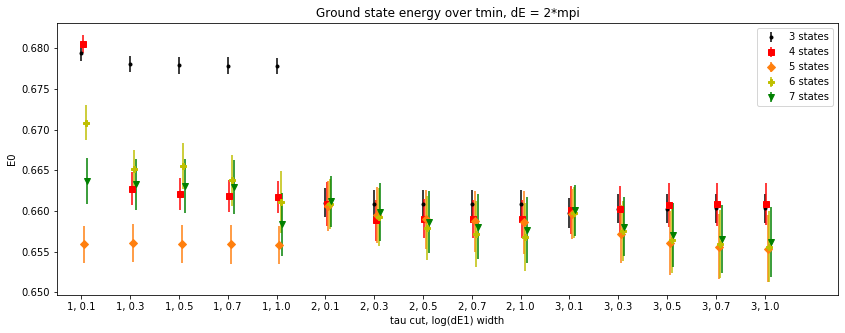

<Figure size 432x288 with 0 Axes>

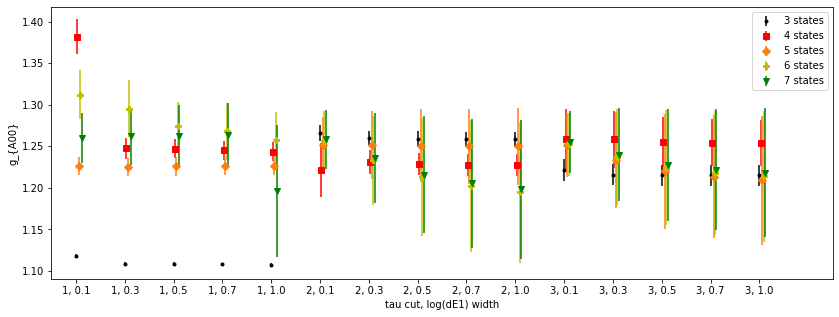

<Figure size 432x288 with 0 Axes>

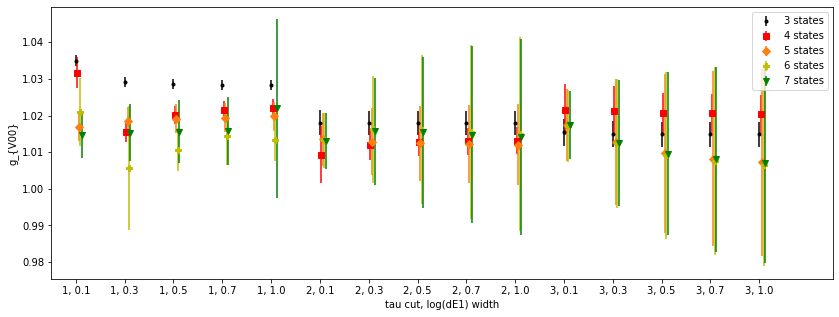

<Figure size 432x288 with 0 Axes>

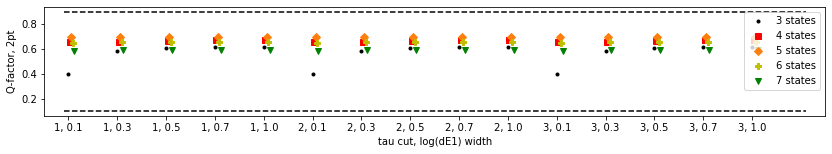

<Figure size 432x288 with 0 Axes>

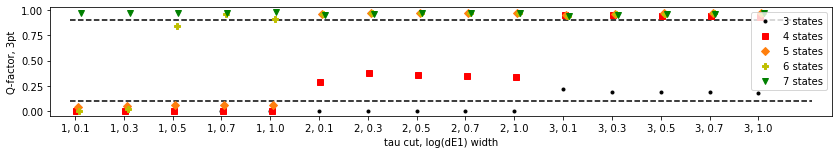

<Figure size 432x288 with 0 Axes>

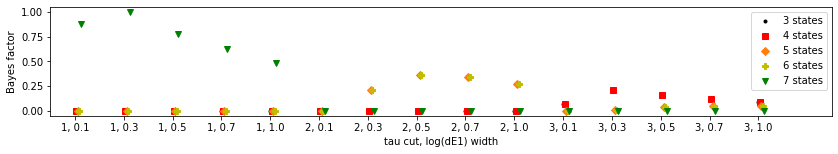

<Figure size 432x288 with 0 Axes>

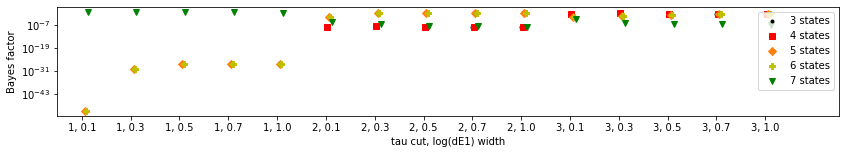

<Figure size 432x288 with 0 Axes>

In [78]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()


# Next, create the figure
#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

<Figure size 432x288 with 0 Axes>

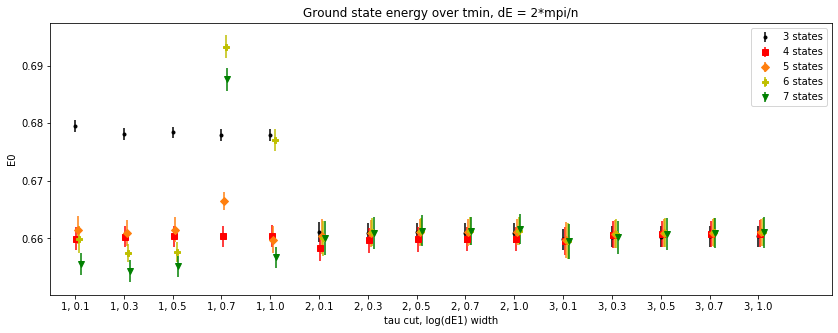

<Figure size 432x288 with 0 Axes>

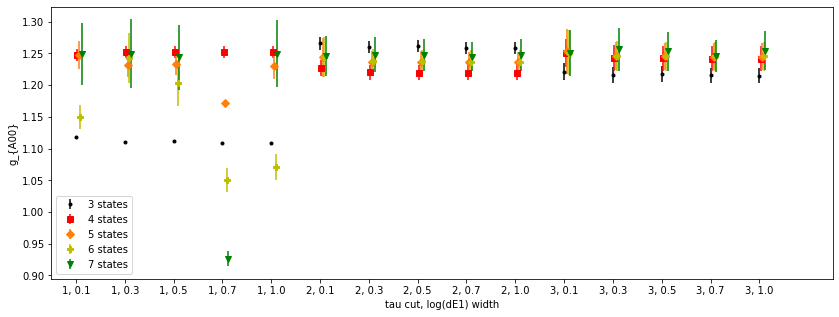

<Figure size 432x288 with 0 Axes>

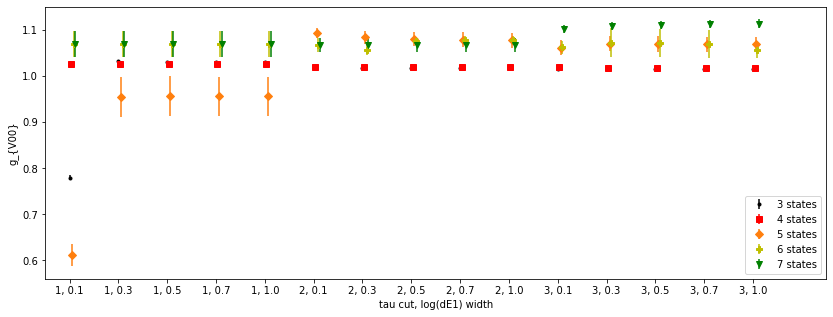

<Figure size 432x288 with 0 Axes>

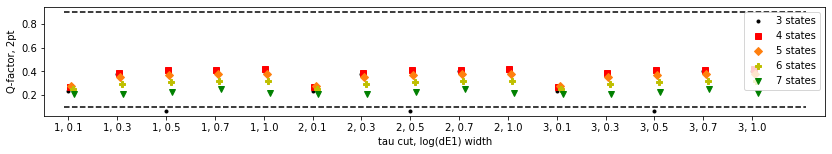

<Figure size 432x288 with 0 Axes>

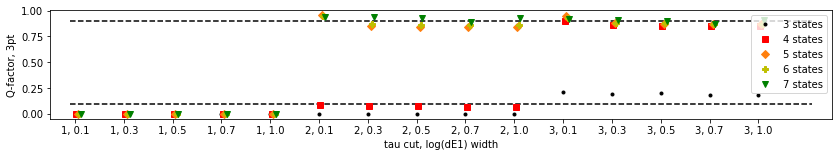

<Figure size 432x288 with 0 Axes>

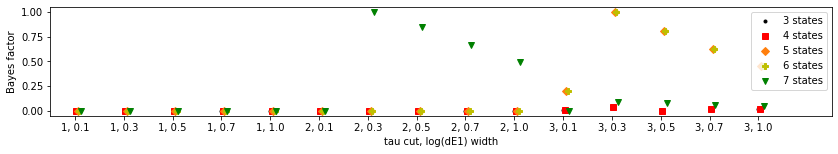

<Figure size 432x288 with 0 Axes>

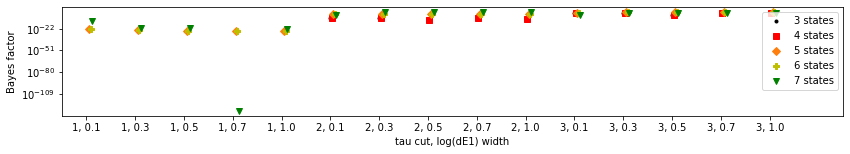

<Figure size 432x288 with 0 Axes>

In [79]:
# Now, 1/n
# Next, create the figure
#E0
plt.clf()
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()



# Next, create the figure
#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

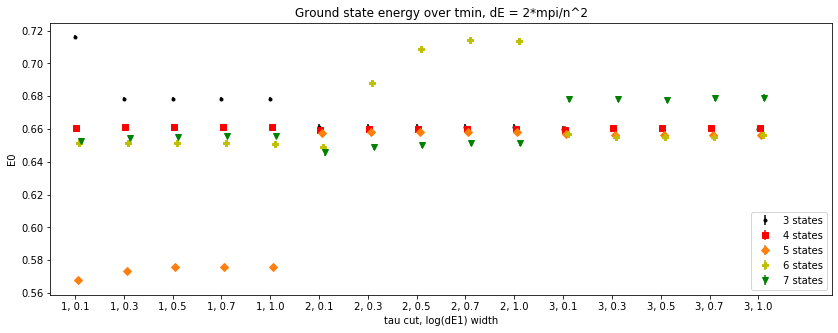

<Figure size 432x288 with 0 Axes>

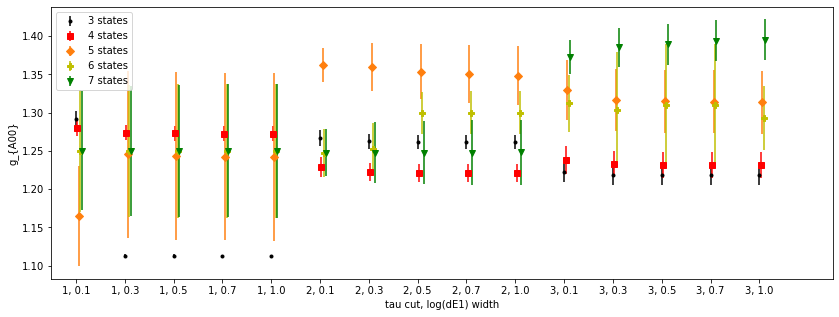

<Figure size 432x288 with 0 Axes>

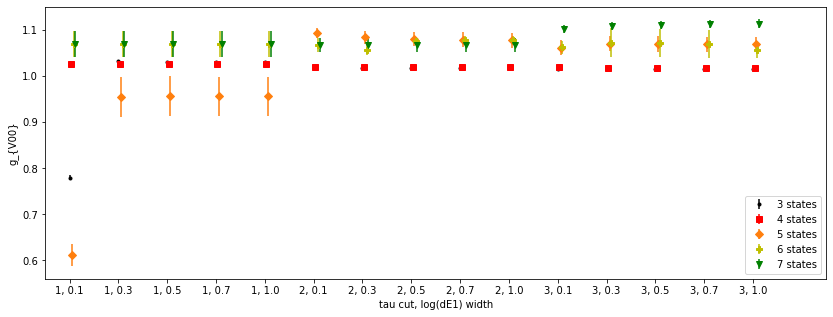

<Figure size 432x288 with 0 Axes>

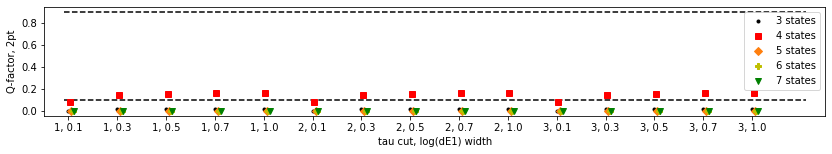

<Figure size 432x288 with 0 Axes>

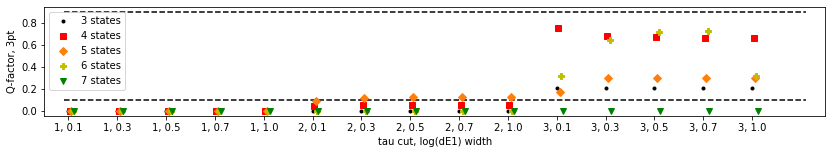

<Figure size 432x288 with 0 Axes>

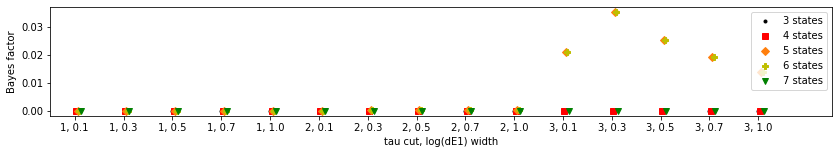

<Figure size 432x288 with 0 Axes>

In [80]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend()
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend()
#plt.ylabel("Bayes factor, 3pt")
#plt.show()